### FOM study via isaura data for LPR


You must choose the file inserted here for this to work

In [155]:
import sys,os,os.path

sys.path.append("../../")   # cite IC from parent directory
                            # NOTE if you can't import IC stuff, its because of the
                            # above line
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import tables as tb
import IC.invisible_cities.io.dst_io                           as     dstio
import IC.invisible_cities.io.mcinfo_io as mcio
from    IC.invisible_cities.core.core_functions   import shift_to_bin_centers
import iminuit,probfit

import scipy.special as special
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

from scipy.integrate import quad

In [2]:
#adding here ROI
emin = 1.5
emax = 1.7

#### Collecting all the data

In [3]:

# list of all files in a folder
folder_path = '../LPR_rerun/PORT_1a/prod/isaura/'
#file = f'isaura/isaura_10_228Th.h5'

file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# NOTE Break this section up, its annoying like this.
dfs = []
df_trs = []
df_ems = []
# create massive dataframe with all of them
for file in file_names:
    file_path = folder_path + file
    df = dstio.load_dst(file_path, 'Tracking', 'Tracks')
    dfs.append(df)
    # include MC particles (boooo takes ages)

    # collecting the correct components of the file, not exactly sure how this works
    df_ps = pd.read_hdf(file_path, 'MC/particles')
    #df_ps = df_ps[df_ps.creator_proc == 'conv']
    # collecting event map
    df_em = mcio.load_eventnumbermap(file_path).set_index('nexus_evt')
    df_trs.append(df_ps)
    df_ems.append(df_em)

tracks = pd.concat(dfs, axis=0, ignore_index=True)

particles = pd.concat(df_trs, ignore_index=True)
eventmap = pd.concat([dt for dt in df_ems])
# create particle list also

In [4]:
print("Tracks: ")
display(tracks.tail())
print(tracks['event'].nunique())
print("")
print("MC data")
display(particles.tail())
print("")
print("Event map:")
display(eventmap.head())

Tracks: 


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
328458,4060710,0,0.572125,48.927675,59,7484,1,314.675,294.675,522.397217,...,525.821166,349.089849,320.664750,551.769409,0.235944,0.037322,0.000000,9.833333,9.428571,4.456444
328459,4060712,0,0.861342,87.723252,103,6380,4,5.675,415.675,335.498718,...,338.256397,25.904968,465.826742,400.302053,0.169192,0.042754,0.000000,9.500000,8.875000,4.836665
328460,4060712,1,0.026480,4.836665,2,79,4,22.675,478.675,414.213104,...,416.042900,24.629322,478.906839,420.872278,0.026480,0.026480,0.026480,9.500000,8.875000,4.836665
328461,4060712,2,0.001016,8.875000,2,28,4,-6.325,440.675,354.365692,...,354.365692,-3.942128,443.310643,354.365692,0.001016,0.001016,0.001016,9.500000,8.875000,4.836665
328462,4060712,3,0.000585,0.000000,1,18,4,65.675,424.675,350.184662,...,350.184662,67.733877,426.232716,350.184662,0.000585,0.000585,0.000585,9.500000,8.875000,4.836665


100009

MC data


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
8041796,2030356,91,e-,False,55,30.259228,426.134430,352.008423,2.193173,30.096209,...,-0.162406,0.015503,-0.008732,0.0,0.0,0.0,0.025482,1.436975,eIoni,eIoni
8041797,2030356,90,e-,False,55,30.279558,429.029327,353.054474,2.120956,30.183689,...,0.064169,0.157650,0.102301,0.0,-0.0,-0.0,0.037231,2.202024,eIoni,eIoni
8041798,2030356,89,e-,False,55,32.744003,438.281555,344.038391,1.840851,32.722652,...,-0.022657,0.085612,0.095038,0.0,0.0,-0.0,0.016253,0.597368,eIoni,eIoni
8041799,2030356,88,e-,False,55,23.930265,443.683899,364.208191,1.648568,23.785473,...,-0.025266,-0.164843,-0.084782,-0.0,0.0,-0.0,0.033170,1.671516,eIoni,eIoni
8041800,2030356,53,Pb208,False,36,396.074768,394.611877,530.918335,0.000739,396.078827,...,2.427084,-0.653481,0.719626,0.0,-0.0,0.0,0.000018,0.004373,RadioactiveDecay,NoProcess



Event map:


,evt_number
nexus_evt,
2540000,5080000
2540001,5080002
2540002,5080004
2540003,5080006
2540004,5080008


#### Checking that the MC data indexing is just half the track index, and matching the indices accordingly

In [5]:
# double check that this is a valid solution

eventmap_reset = eventmap.reset_index()
display(eventmap_reset)

if not (eventmap_reset['nexus_evt'] * 2 == eventmap_reset['evt_number']).all():
    print("Falses in here!")
else:
    print("No Falses to be seen!")

,nexus_evt,evt_number
0,2540000,5080000
1,2540001,5080002
2,2540002,5080004
3,2540003,5080006
4,2540004,5080008
...,...,...
100004,2030352,4060704
100005,2030353,4060706
100006,2030354,4060708
100007,2030355,4060710


No Falses to be seen!


In [6]:
# So we're updating it here
particles['event_id'] = particles['event_id'] * 2 
display(particles.head())

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,5080000,1,Tl208,True,0,397.564026,392.015442,534.536865,0.000000,397.564026,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,none,RadioactiveDecay
1,5080000,4,e-,False,1,397.564026,392.015442,534.536865,0.001609,407.646332,...,0.866701,-0.327340,0.002752,-0.000000,-0.000000,0.000000,0.547042,32.554752,RadioactiveDecay,eIoni
2,5080000,3,anti_nu_e,False,1,397.564026,392.015442,534.536865,0.001609,11181.164062,...,0.723798,-0.865316,0.547861,0.723798,-0.865316,0.547861,1.254116,18684.607422,RadioactiveDecay,Transportation
3,5080000,2,Pb208[3197.711],False,1,397.564026,392.015442,534.536865,0.001609,397.564026,...,-1.590499,1.192656,-0.550613,-0.000000,0.000000,-0.000000,0.000011,0.000000,RadioactiveDecay,RadioactiveDecay
4,5080000,6,gamma,False,2,397.564026,392.015442,534.536865,0.001609,164.141830,...,-0.455762,0.228695,0.282998,-0.000000,0.000000,-0.000000,0.583188,1501.569824,RadioactiveDecay,phot


#### Select a specific event just to check for anything weird happening

In [7]:
# select a specific event
n = 2
evnt = tracks.event.unique()[n]
print("Event of interest: {}".format(evnt))

trk = tracks[tracks.event==evnt]
trk.head()

Event of interest: 5080004


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
13,5080004,0,0.475175,32.04773,19,4159,4,12.675,-316.325,147.604263,...,154.888442,26.338924,-287.808455,155.155294,0.392980,0.362969,0.280775,10.0,9.222222,4.83697
14,5080004,1,0.000826,0.00000,1,28,4,36.675,-259.325,154.847458,...,154.847458,38.559927,-256.434284,154.847458,0.000826,0.000826,0.000826,10.0,9.222222,4.83697
15,5080004,2,0.000476,0.00000,1,21,4,22.675,-336.325,159.047852,...,159.047852,24.360200,-334.110790,159.047852,0.000476,0.000476,0.000476,10.0,9.222222,4.83697
16,5080004,3,0.000204,0.00000,1,12,4,69.675,-285.325,153.809357,...,153.809357,71.210282,-284.312488,153.809357,0.000204,0.000204,0.000204,10.0,9.222222,4.83697


#### Starting the cuts here

The below cell includes all the required functions for cutting and beyond

In [301]:
def cut_effic(df1, df2, verbose = False):
    '''
    Prints efficiency of cuts for singular cut
    df1 -> cut df
    df2 -> initial df
    '''
    length_1 = df1['event'].nunique()
    length_2 = df2['event'].nunique()
    efficiency = ((length_1/length_2)*100)
    print("Efficiency: {:.2f} %".format(efficiency))

    if (verbose == True):
        print(("Events in reduced dataframe: {}\nEvents in initial dataframe: {}").format(len(df1), len(df2)))

    return efficiency




def plot_hist(df, column = 'energy', binning = 20, title = "Energy plot", output = True, fill = True, label = 'default', x_label = 'energy (MeV)', range = 0, data = False):
    '''
    Print a histogram of energy from our dataframe,.
    '''
    # for simplicity/readability, scoop out the relevant columns from the pandas dataframe.
    energy_vals = df[column].to_numpy()

    if (range==0):
        range = (np.min(energy_vals), np.max(energy_vals))

    # control viewing of hist
    if (fill == True):
        cnts, edges, patches = plt.hist(energy_vals, bins = binning, label = label, range = range)
    else:
        cnts, edges, patches = plt.hist(energy_vals, bins = binning, label = label, histtype='step', linewidth = 2, range = range)
    plt.title(title)
    plt.ylabel("events")
    plt.xlabel(x_label)
    if (output==True):
        plt.show()
    if (data==True):
        return (cnts, edges, patches)
    else:
        return




def fiducial_track_cut_2(df, lower_z = 20, upper_z = 1195, r_lim = 472, verbose = False):
    '''
    Produces fiducial track cuts while removing all events that have outer fiducial tracks
    '''
    # create lists of outer_fiduc entries
    z_df_low = df[(df['z_min'] <= lower_z)]
    z_df_up = df[(df['z_max'] >= upper_z)]
    r_df = df[(df['r_max'] >= r_lim)]

    # scrape the events
    low_list = (z_df_low['event'].to_numpy())
    up_list = (z_df_up['event'].to_numpy())
    r_list = (r_df['event'].to_numpy())

    # apply the filter to remove all events that fall in outer fiduc
    df1 = df[~df['event'].isin(low_list)]
    df2 = df1[~df1['event'].isin(up_list)]
    df3 = df2[~df2['event'].isin(r_list)]

    if (verbose == True):
        print("Cutting events around fiducial volume related to:\nZ range between {} and {}\nRadius range < {}".format(lower_z, upper_z, r_lim))


    return df3




def one_track_cuts(df, verbose = False):
    '''
    Remove events with more than one track
    THERE IS A COLUMN WITH THIS INFO IN IT, CALCULATING IT IS UNNECESSARY
    '''
    # 1-track event counter
    event_counts = df.groupby('event').size()
    #print(event_counts[:5]) # showing that you see how many 
                            #  trackIDs there are per event
    one_track = event_counts[event_counts == 1].index

    # filter dataframe
    one_track_events = df[df['event'].isin(one_track)]
    

    if (verbose == True):
        print("Removing events with more than one track.")
        print("Events with one track: {}".format(one_track))
        display(one_track_events.head())
    

    return one_track_events




def overlapping_cuts(df, verbose = False):
    '''
    Remove all events with energy overlap != 0
    '''

    ovlp_remove = df[df['ovlp_blob_energy']==0]

    if (verbose==True):
        print("Removing overlapping blobs...")

    return ovlp_remove




def energy_cuts(df, lower_e = 1.5, upper_e = 1.7, verbose = False):
    '''
    Apply cuts around the relevant energy
    '''
    filt_e_df = df[(df['energy'] >= lower_e) & (df['energy'] <= upper_e)]

    if (verbose == True):
        print("Cutting energy events around {} & {} keV".format(lower_e, upper_e))

    return filt_e_df




def len_events(df):
    '''
    Returns the number of unique events as len(df) doesn't work in this case
    '''
    length_1 = df['event'].nunique()
    return length_1




def plot_volume_hists(df):

    plot_hist(df, column = 'x_min', output = False, label = 'x_min', fill = False, x_label = 'position (mm)')
    plot_hist(df, column = 'x_max', title = 'x plot for full volume', output = False, label = 'x_max', fill = False, x_label = 'position (mm)')
    plt.legend(loc='upper left')
    plt.show()

    plot_hist(df, column = 'y_min', output = False, label = 'y_min', fill = False, x_label = 'position (mm)')
    plot_hist(df, column = 'y_max', title = 'y plot for full volume', output = False, label = 'y_max', fill = False, x_label = 'position (mm)')
    plt.legend(loc='upper left')
    plt.show()

    plot_hist(df, column = 'z_min', output = False, label = 'z_min', fill = False, x_label = 'position (mm)')
    plot_hist(df, column = 'z_max', title = 'z plot for full volume', output = False, label = 'z_max', fill = False, x_label = 'position (mm)')
    plt.legend(loc='upper left')
    plt.show()

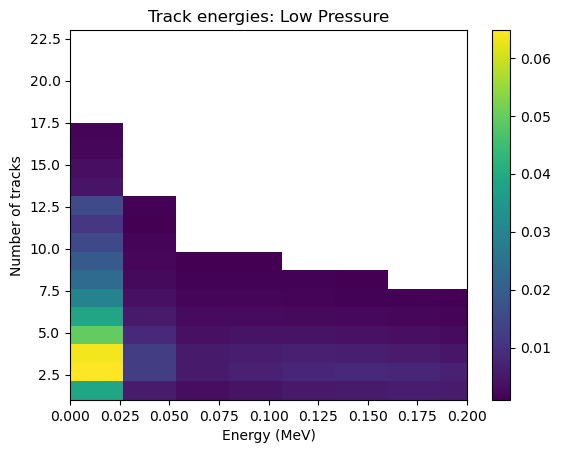

In [9]:
# useful to normalize histograms
def get_weights(data, norm):
    if norm:
        return np.repeat(1.0/len(data), len(data))
    else:
        return np.repeat(1.0, len(data))

track_energy = tracks.energy
track_no = tracks.numb_of_tracks
# normalise
weights = get_weights(track_energy, True)
#plt.hist2d(track_energy, track_no, bins=(50, 20), cmin=0.001)
plt.hist2d(track_energy, track_no, weights = weights, bins=(100, 20), cmin=0.001)
plt.xlim([0,0.2])
plt.title("Track energies: Low Pressure")
plt.xlabel('Energy (MeV)')
plt.ylabel('Number of tracks')
plt.colorbar()
plt.show()

### Remove low energy events

In [10]:
def remove_low_E_events(df, energy_limit = 0.05):
    '''
    Remove low energy tracks, add their energy back to the first
    track and then update 'numb_of_tracks' to be up to date
    '''

    tracks_test = df.copy(deep=True)

    # take events with lower than 50 keV, 0.05 MeV
    condition = (tracks_test.energy < energy_limit)
    summed_df = tracks_test[condition].groupby('event')['energy'].sum().reset_index()

    # merge these as a new column
    merged_df = pd.merge(tracks_test, summed_df, on='event', suffixes=('', '_sum'))

    # add this summed energy to first column
    merged_df['energy'] = merged_df.apply(lambda row: (row['energy'] + row['energy_sum']) if row.name == merged_df[merged_df['event'] == row['event']].index[0] else row['energy'], axis=1)

    # drop energy sum column
    result_df = merged_df.drop('energy_sum', axis = 1)

    # then remove all tracks below the energy threshold
    condition_upper = (result_df.energy > energy_limit)
    remove_low_E = result_df[condition_upper]

    # count the number of events identified with unique event, and change numb_of_tracks to reflect this
    event_counts = remove_low_E['event'].value_counts(sort = False)

    # apply this to numb_of_tracks
    remove_low_E['numb_of_tracks'] = remove_low_E['event'].map(event_counts)

    return remove_low_E

##### Cuts

We want to:
- Remove low energy events (as shown above)
- Include events within the fiducial volume [r < 472mm; 20 mm < z < 1195mm]
- only include 1-track events
- No overlapping blobs
- Energy cut for thallium [1.5, 1.7] MeV


### Low energy cut

In [11]:
# Low energy cut
display(tracks.head(10))
low_e_cut_tracks = remove_low_E_events(tracks)
display(low_e_cut_tracks.head(10))

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,5080000,0,1.039447,106.957101,130,10660,4,368.675,160.675,334.439758,...,346.618662,395.709598,257.212595,386.899102,0.549273,0.021990,0.000000,9.857143,9.928571,4.809897
1,5080000,1,0.013352,4.809897,2,47,4,388.675,270.675,440.460083,...,441.936821,389.120948,279.638220,446.759552,0.013352,0.013352,0.013352,9.857143,9.928571,4.809897
2,5080000,2,0.010388,0.000000,1,65,4,378.675,254.675,408.962036,...,409.787137,381.749030,256.750470,409.787137,0.010388,0.010388,0.010388,9.857143,9.928571,4.809897
3,5080000,3,0.001319,0.000000,1,21,4,378.675,254.675,424.692047,...,424.692047,381.261911,256.890582,424.692047,0.001319,0.001319,0.001319,9.857143,9.928571,4.809897
4,5080002,0,0.962756,77.756812,74,5810,9,-87.325,359.675,612.663391,...,648.421388,-43.764823,403.787828,615.673530,0.306094,0.030088,0.000000,9.750000,9.571429,4.951324
5,5080002,1,0.731305,74.337640,72,4647,9,-98.325,411.675,604.282959,...,649.717506,-93.095078,423.334631,611.416833,0.375550,0.144682,0.000000,9.750000,9.571429,4.951324
6,5080002,2,0.168541,20.685177,10,850,9,127.675,353.675,498.257599,...,501.543143,131.322157,369.363285,505.352041,0.166143,0.145188,0.142790,9.750000,9.571429,4.951324
7,5080002,3,0.140927,58.630464,23,793,9,52.675,348.675,513.979492,...,516.101429,53.955545,349.802676,526.248103,0.088264,0.021532,0.000000,9.750000,9.571429,4.951324
8,5080002,4,0.074157,14.532390,5,290,9,-20.325,376.675,587.473511,...,594.815981,-4.176398,379.414310,588.386162,0.074157,0.074157,0.074157,9.750000,9.571429,4.951324
9,5080002,5,0.017627,10.776263,2,32,9,28.675,347.675,555.981140,...,560.994456,28.675000,360.638246,555.981140,0.017627,0.017627,0.017627,9.750000,9.571429,4.951324


/tmp/ipykernel_7841/261361389.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remove_low_E['numb_of_tracks'] = remove_low_E['event'].map(event_counts)


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,5080000,0,1.064505,106.957101,130,10660,1,368.675,160.675,334.439758,...,346.618662,395.709598,257.212595,386.899102,0.549273,0.021990,0.000000,9.857143,9.928571,4.809897
4,5080002,0,0.990687,77.756812,74,5810,5,-87.325,359.675,612.663391,...,648.421388,-43.764823,403.787828,615.673530,0.306094,0.030088,0.000000,9.750000,9.571429,4.951324
5,5080002,1,0.731305,74.337640,72,4647,5,-98.325,411.675,604.282959,...,649.717506,-93.095078,423.334631,611.416833,0.375550,0.144682,0.000000,9.750000,9.571429,4.951324
6,5080002,2,0.168541,20.685177,10,850,5,127.675,353.675,498.257599,...,501.543143,131.322157,369.363285,505.352041,0.166143,0.145188,0.142790,9.750000,9.571429,4.951324
7,5080002,3,0.140927,58.630464,23,793,5,52.675,348.675,513.979492,...,516.101429,53.955545,349.802676,526.248103,0.088264,0.021532,0.000000,9.750000,9.571429,4.951324
8,5080002,4,0.074157,14.532390,5,290,5,-20.325,376.675,587.473511,...,594.815981,-4.176398,379.414310,588.386162,0.074157,0.074157,0.074157,9.750000,9.571429,4.951324
13,5080004,0,0.476680,32.047730,19,4159,1,12.675,-316.325,147.604263,...,154.888442,26.338924,-287.808455,155.155294,0.392980,0.362969,0.280775,10.000000,9.222222,4.836970
17,5080008,0,0.342280,24.071850,14,2603,2,214.675,207.675,251.550385,...,254.884531,226.959512,217.030879,268.335009,0.308192,0.307513,0.303585,9.166667,9.684211,4.927902
18,5080008,1,0.115869,10.865917,3,790,2,241.675,346.675,439.461395,...,441.972932,246.387016,360.039896,445.648195,0.115869,0.115869,0.115869,9.166667,9.684211,4.927902
20,5080010,0,1.271544,77.117883,103,10104,2,-88.325,56.675,1118.789551,...,1120.857091,-52.379341,61.995799,1160.489484,0.505458,0.074204,0.000000,9.222222,9.942857,4.964774


65766


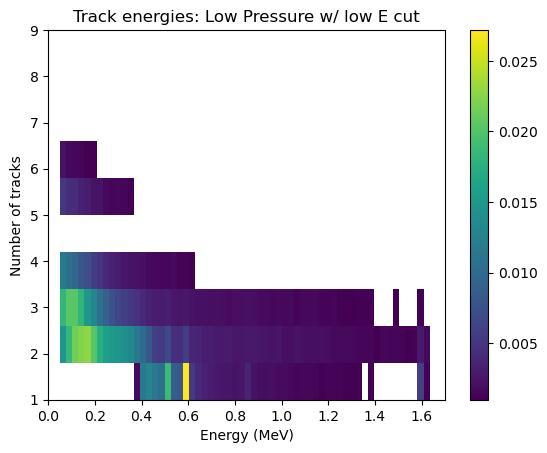

In [12]:
print(len_events(low_e_cut_tracks))

track_energy = low_e_cut_tracks.energy
track_no = low_e_cut_tracks.numb_of_tracks
# normalise
weights = get_weights(track_energy, True)
#plt.hist2d(track_energy, track_no, bins=(50, 20), cmin=0.001)
plt.hist2d(track_energy, track_no, weights = weights, bins=(100, 10), cmin=0.001)
plt.title("Track energies: Low Pressure w/ low E cut")
plt.xlabel('Energy (MeV)')
plt.ylabel('Number of tracks')
plt.xlim([0,1.7])
plt.colorbar()
plt.show()

In [13]:
# Efficiency calculation
cut_names = []
rel_cut_effics = []
abs_cut_effics = []
cut_events = []

# no cuts
cut_names.append("No cuts")
rel_cut_effics.append(100)
abs_cut_effics.append(100)
# number of events
cut_events.append(len_events(tracks))


# low energy cut
cut_names.append("low E cuts")

# make efficiency calculation
print("Low E cut")
print("==================")
ef = cut_effic(low_e_cut_tracks, tracks)

# add efficiency calculation
rel_cut_effics.append(ef)
cut_events.append(len_events(low_e_cut_tracks))
abs_cut_effics.append(ef)

Low E cut
Efficiency: 65.76 %


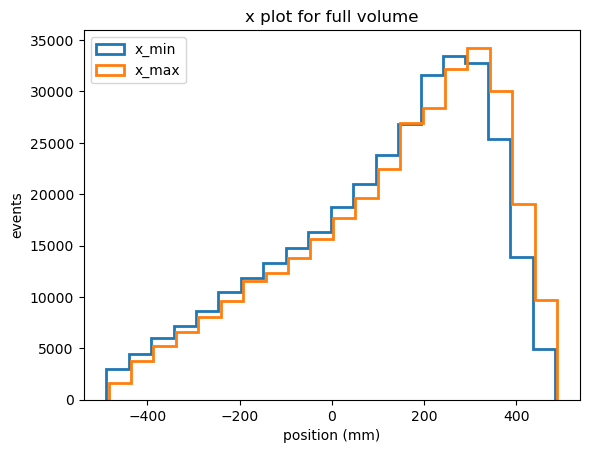

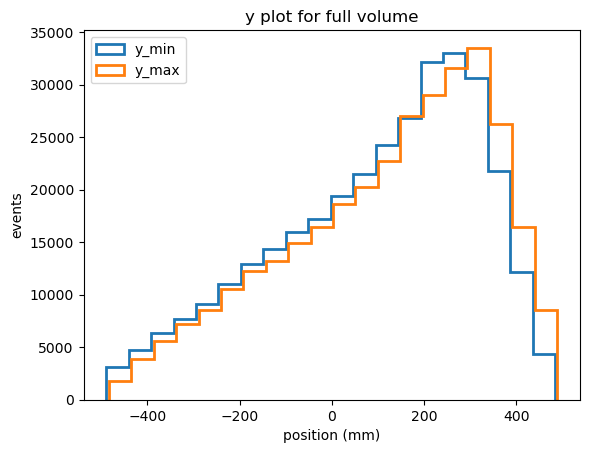

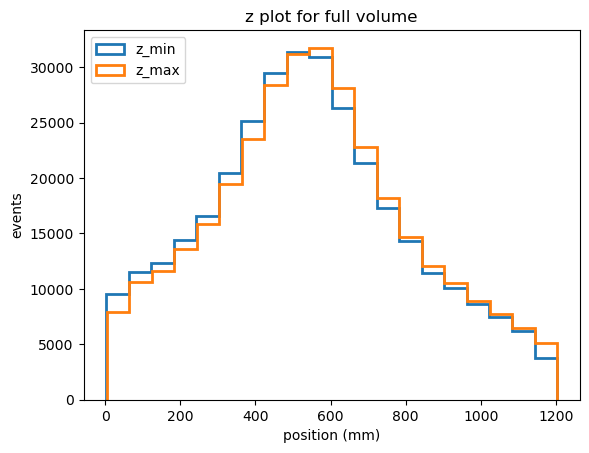

In [14]:
# plotting the positional histograms
plot_volume_hists(tracks)

# Fiducial cuts

In [15]:


cut_names.append("Fiducial Cuts")

# make fiducial cuts
fiducial_rel = fiducial_track_cut_2(low_e_cut_tracks, lower_z = 20, upper_z=1195, r_lim = 472, verbose = False)

fiducial_abs = fiducial_track_cut_2(tracks, lower_z = 20, upper_z=1195, r_lim = 472, verbose = True)

# make efficiency calculation
print("Fiducial track cut")
print("==================")
print("Relative Cut efficiency:")
ef = cut_effic(fiducial_rel, low_e_cut_tracks)
rel_cut_effics.append(ef)
cut_events.append(len_events(fiducial_rel))

print('Absolute Cut efficiency:')
ef = cut_effic(fiducial_abs, tracks)
abs_cut_effics.append(ef)


Cutting events around fiducial volume related to:
Z range between 20 and 1195
Radius range < 472
Fiducial track cut
Relative Cut efficiency:
Efficiency: 70.63 %
Absolute Cut efficiency:
Efficiency: 66.76 %


# One track cut

In [16]:
# relative

cut_names.append("One track cut")
one_track_rel = one_track_cuts(fiducial_rel, verbose = False)

# events are relative, as absolute efficiency lets you figure out events from the beginning# absolute
one_track_abs = one_track_cuts(tracks)

## sanity check here
#print(len_events(one_track_rel), len_events(one_track_abs), len_events(tracks))

# relative
print("Single track cut")
print("================")
print("Relative Cut efficiency:")
ef = cut_effic(one_track_rel, fiducial_rel)
rel_cut_effics.append(ef)
cut_events.append(len_events(one_track_rel))

# absolute
print("Absolute Cut efficiency:")
ef = cut_effic(one_track_abs, tracks)
abs_cut_effics.append(ef)

Single track cut
Relative Cut efficiency:
Efficiency: 43.37 %
Absolute Cut efficiency:
Efficiency: 17.97 %


# Overlapping blob cuts

In [17]:
# apply cuts
ovlp_rel = overlapping_cuts(one_track_rel)
ovlp_abs = overlapping_cuts(tracks)

cut_names.append("Blob overlap cuts")

# relative
print("Blob overlap cut")
print("================")
print("Relative Cut efficiency:")
ef = cut_effic(ovlp_rel, one_track_rel)
rel_cut_effics.append(ef)
cut_events.append(len_events(ovlp_rel))


# absolute
print("Absolute Cut efficiency:")
ef = cut_effic(ovlp_abs, tracks)
abs_cut_effics.append(ef)

Blob overlap cut
Relative Cut efficiency:
Efficiency: 50.19 %
Absolute Cut efficiency:
Efficiency: 53.24 %


# Energy cut

In [18]:
ecut_rel = energy_cuts(ovlp_rel)
ecut_abs = energy_cuts(tracks)

cut_names.append("Energy cuts")

# relative
print("Energy cut")
print("================")
print("Relative Cut efficiency:")
ef = cut_effic(ecut_rel, ovlp_rel)
rel_cut_effics.append(ef)
cut_events.append(len_events(ecut_rel))


# absolute
print("Absolute Cut efficiency:")
ef = cut_effic(ecut_abs, tracks)
abs_cut_effics.append(ef)

Energy cut
Relative Cut efficiency:
Efficiency: 11.90 %
Absolute Cut efficiency:
Efficiency: 5.07 %


In [19]:
efficiencies = pd.DataFrame({'Cut': cut_names,
                             'Relative Efficiency': rel_cut_effics,
                             'Relative Events': cut_events,
                             'Single Cut Efficiency': abs_cut_effics
                             })

display(efficiencies)
print("Single Cut Efficiency: each cut on the original unmodified data set\nRelative Efficiency: each cut efficiency wrt the previous cut")

,Cut,Relative Efficiency,Relative Events,Single Cut Efficiency
0,No cuts,100.000000,100009,100.000000
1,low E cuts,65.760082,65766,65.760082
2,Fiducial Cuts,70.627680,46449,66.763991
3,One track cut,43.367995,20144,17.972382
4,Blob overlap cuts,50.193606,10111,53.236209
5,Energy cuts,11.897933,1203,5.066544


Single Cut Efficiency: each cut on the original unmodified data set
Relative Efficiency: each cut efficiency wrt the previous cut


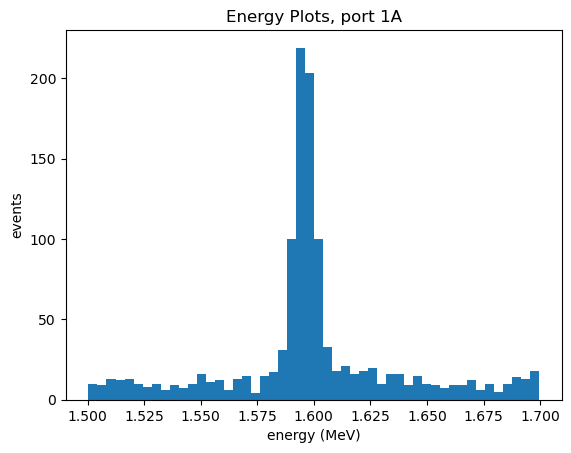

In [20]:
# just for visualising it
plot_hist(ecut_rel, binning = 50, title = 'Energy Plots, port 1A')


In [21]:
# checking out some of the stranger tracks
display(low_e_cut_tracks[low_e_cut_tracks['numb_of_tracks'] == 2].head(10))

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
17,5080008,0,0.342280,24.071850,14,2603,2,214.675,207.675,251.550385,...,254.884531,226.959512,217.030879,268.335009,0.308192,0.307513,0.303585,9.166667,9.684211,4.927902
18,5080008,1,0.115869,10.865917,3,790,2,241.675,346.675,439.461395,...,441.972932,246.387016,360.039896,445.648195,0.115869,0.115869,0.115869,9.166667,9.684211,4.927902
20,5080010,0,1.271544,77.117883,103,10104,2,-88.325,56.675,1118.789551,...,1120.857091,-52.379341,61.995799,1160.489484,0.505458,0.074204,0.000000,9.222222,9.942857,4.964774
21,5080010,1,0.142156,10.473699,4,1120,2,-84.325,355.675,578.050293,...,580.458542,-73.057690,361.110007,583.747191,0.142156,0.142156,0.142156,9.222222,9.942857,4.964774
47,5080020,0,1.893940,196.647742,225,11614,2,253.675,149.675,367.020935,...,466.688660,287.706937,161.637783,399.086752,0.115920,0.028134,0.000000,9.272727,9.842105,4.969414
48,5080020,1,0.204253,49.680511,26,1214,2,314.675,287.675,512.918396,...,517.890633,345.111094,330.487001,532.282374,0.103916,0.057766,0.000000,9.272727,9.842105,4.969414
75,5080042,0,0.782268,67.584491,82,6541,2,-133.325,-74.325,756.522827,...,773.263561,-105.325000,-11.830532,760.730286,0.549755,0.032951,0.000000,9.111111,9.500000,4.898193
76,5080042,1,0.196961,108.759390,71,1878,2,-104.325,-57.325,673.573486,...,731.312683,-68.349143,-10.329017,673.573486,0.034387,0.031304,0.000000,9.111111,9.500000,4.898193
84,5080050,0,0.244963,14.913095,5,1352,2,245.675,95.675,107.699036,...,110.803996,258.291790,101.760858,113.083777,0.214040,0.214040,0.214040,9.978723,9.913043,4.955506
85,5080050,1,0.158183,14.913095,8,1896,2,-194.325,-83.325,489.836517,...,492.552351,-181.709082,-70.599370,496.514626,0.158183,0.158183,0.158183,9.978723,9.913043,4.955506


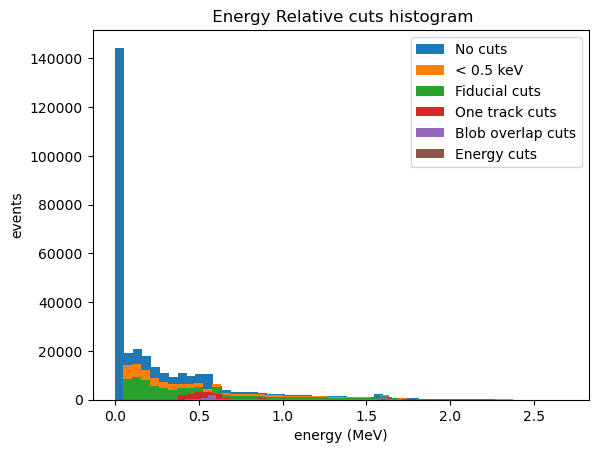

In [24]:
plot_hist(tracks, label = 'No cuts', output = False, binning = 50)
plot_hist(low_e_cut_tracks, label = '< 0.5 keV', output = False, binning = 50)
plot_hist(fiducial_rel, label = 'Fiducial cuts', output = False, binning = 50)
plot_hist(one_track_rel, label = 'One track cuts', output = False, binning = 50)
plot_hist(ovlp_rel, label = 'Blob overlap cuts', output = False, binning = 50)
plot_hist(ecut_rel, label = 'Energy cuts', output = False, title=' Energy Relative cuts histogram')
plt.legend()
plt.show()

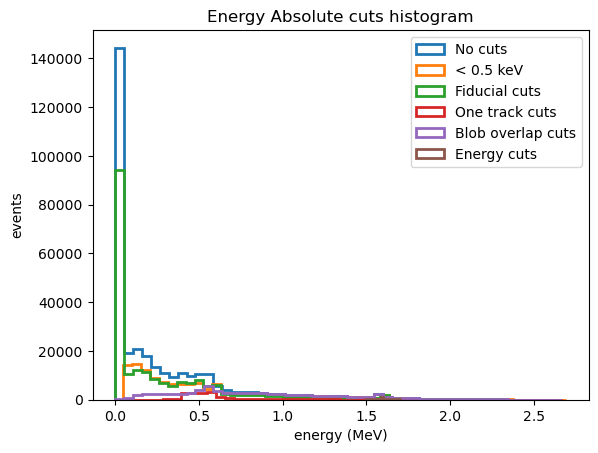

In [25]:
plot_hist(tracks, label = 'No cuts', output = False, binning = 50, fill = False)
plot_hist(low_e_cut_tracks, label = '< 0.5 keV', output = False, binning = 50, fill = False)
plot_hist(fiducial_abs, label = 'Fiducial cuts', output = False, binning = 50, fill = False)
plot_hist(one_track_abs, label = 'One track cuts', output = False, binning = 50, fill = False)
plot_hist(ovlp_abs, label = 'Blob overlap cuts', output = False, binning = 50, fill = False)
plot_hist(ecut_abs, label = 'Energy cuts', output = False, title='Energy Absolute cuts histogram', fill = False)
plt.legend()
plt.show()

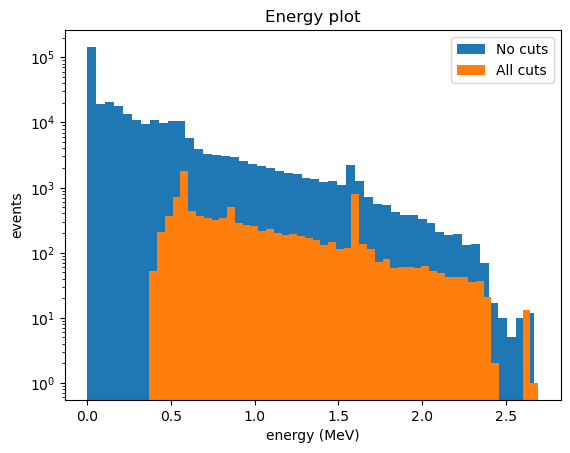

In [26]:
plot_hist(tracks, label = 'No cuts', output = False, binning = 50)
plot_hist(ovlp_rel, label = 'All cuts', output = False, binning = 50)
plt.yscale('log')
plt.legend()
plt.show()

0.01220472498683842 0.9365000546868977


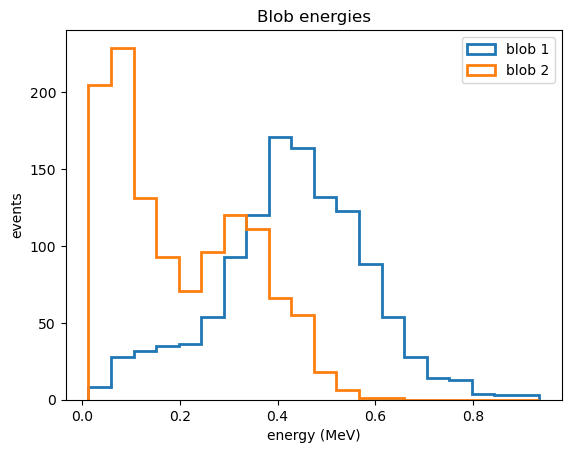

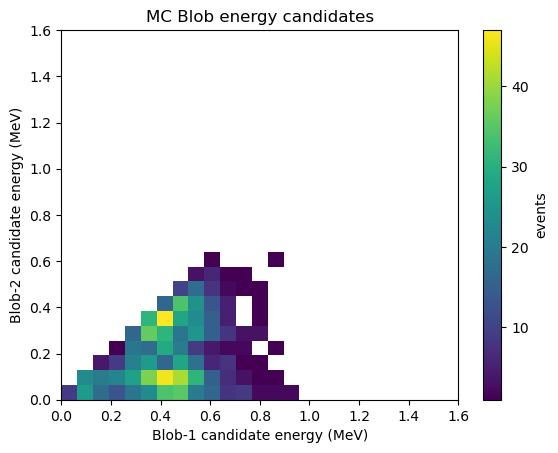

In [27]:
# plot blob energies

# make range full range of blob1 and blob2
eblob_full = []
eblob_full.append(ecut_rel['eblob1'].to_numpy())
eblob_full.append(ecut_rel['eblob2'].to_numpy())

minimum_e = np.min(eblob_full)
maximum_e = np.max(eblob_full)
#print(minimum_e, maximum_e)

plot_hist(ecut_rel, column = 'eblob1', binning = 20, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plot_hist(ecut_rel, column = 'eblob2', binning = 20, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plt.legend()
plt.show()

# blob 2dhist
plt.hist2d(ecut_rel['eblob1'], ecut_rel['eblob2'], bins=(25, 25), range=((0, 1.6), (0, 1.6)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (MeV)")
plt.ylabel("Blob-2 candidate energy (MeV)")
plt.title("MC Blob energy candidates")
plt.show()

# Collecting all e+e- events 

In [44]:
# create e+ dataframe only
positron_df = pd.DataFrame(columns=particles.columns)

condition = (particles['particle_name'] == 'e+')
positron_events = positron_df.append(particles.loc[condition], ignore_index=True)
print("True events with positrons:")
display(positron_events.head(20))

# collect events
pos_events = np.unique(positron_events['event_id'].to_numpy())
print("Total number of positron events: {}".format(len(pos_events)))
#print(pos_events)


# collect all events that dont match this list
ecut_no_positron_df = ecut_rel[~ecut_rel['event'].isin(pos_events)]

print("Isaura events with no positrons")
display(ecut_no_positron_df.head(20))

# events with positrons only in here!
ecut_positron_df = ecut_rel[ecut_rel['event'].isin(pos_events)]

print("Isaura events with positrons:")
display(ecut_positron_df.head(20))

# Check that we get all the data, should print true (which it does) 
print("Isaura events total: {}\nPositron Events: {}\nNon-positron events: {}\nDoes this add up? {}".format(len(ecut_rel),len(ecut_positron_df), len(ecut_no_positron_df), len(ecut_positron_df) + len(ecut_no_positron_df) == len(ecut_rel)))
print()

# make range full range of blob1 and blob2...
eblob_full = []
eblob_full.append(ecut_rel['eblob1'].to_numpy())
eblob_full.append(ecut_rel['eblob2'].to_numpy())

#...so that we can produce the min and max blob energy
minimum_e = np.min(eblob_full)
maximum_e = np.max(eblob_full)
#print(minimum_e, maximum_e)


True events with positrons:


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,5080008,42,e+,False,40,399.615417,394.366058,536.815430,0.004905,399.746094,...,0.780250,0.557767,1.590467,-0.0,-0.0,0.0,1.415293,1.324204,conv,annihil
1,5080032,32,e+,False,30,-166.862320,-370.026581,1148.358154,3.770954,-198.535721,...,-0.247377,-0.461457,1.173200,0.0,0.0,-0.0,0.871628,187.018860,conv,annihil
2,5080036,37,e+,False,35,-65.955795,324.198029,272.437469,1.781441,-22.099428,...,-1.258216,-0.110806,-0.581811,0.0,-0.0,0.0,0.970557,263.940033,conv,annihil
3,5080048,18,e+,False,16,394.422913,407.527100,535.740845,0.035130,394.485077,...,0.217861,0.929769,-0.199142,0.0,-0.0,0.0,0.590233,0.248721,conv,annihil
4,5080050,43,e+,False,41,466.010071,219.144073,487.874298,0.656721,466.172241,...,0.595691,-1.389832,-0.308319,0.0,0.0,0.0,1.114628,0.823723,conv,annihil
5,5080066,40,e+,False,38,427.781158,377.352051,442.963135,0.340736,428.130005,...,0.537648,-0.716717,-1.240047,-0.0,0.0,-0.0,1.101944,0.871644,conv,annihil
6,5080080,46,e+,False,38,426.655273,364.533203,592.671570,0.232653,426.677277,...,0.462149,-0.210924,0.238228,-0.0,0.0,-0.0,0.247910,0.071758,conv,annihil
7,5080136,39,e+,False,37,477.058289,-86.245613,347.050385,1.740581,374.990082,...,-1.460626,-0.183496,0.252609,0.0,-0.0,0.0,1.067617,277.627106,conv,annihil
8,5080138,38,e+,False,36,-63.345615,-213.545135,977.998840,2.941550,-61.490604,...,0.078129,-0.363009,0.665113,-0.0,-0.0,-0.0,0.406266,69.172440,conv,annihil
9,5080172,52,e+,False,50,-32.611187,216.488098,1540.216064,3.699887,-32.628563,...,-0.335066,0.032621,0.565033,0.0,0.0,0.0,0.321897,0.147108,conv,annihil


Total number of positron events: 13282
Isaura events with no positrons


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
3515,1140492,0,1.669786,233.309827,204,12918,1,57.675,117.675,440.489655,...,490.889092,175.318193,260.128009,485.496568,0.091418,0.087760,0.0,9.461538,9.866667,4.861750
3702,1140630,0,1.581736,273.332373,216,12999,1,242.675,-28.325,584.348755,...,675.480459,329.054850,169.358805,592.509623,0.205684,0.093228,0.0,9.400000,9.708333,4.968898
5308,80494,0,1.582480,330.954116,199,11468,1,-171.325,191.675,361.742035,...,413.814469,13.569987,300.847950,399.401761,0.539764,0.060859,0.0,9.843750,9.727273,4.851889
6320,20636,0,1.571437,249.941362,221,11667,1,-9.325,-125.325,337.597870,...,345.630757,78.387606,-6.285645,469.961256,0.496032,0.045397,0.0,9.300000,9.466667,4.936755
6854,3900390,0,1.565809,208.107233,199,11506,1,67.675,108.675,266.212097,...,268.671921,91.061872,119.425802,379.966581,0.252862,0.225029,0.0,9.125000,9.785714,4.852577
7364,1560084,0,1.607787,276.867071,215,12368,1,-132.325,158.675,31.159515,...,33.029529,-73.451906,319.656001,68.769089,0.344663,0.101011,0.0,9.333333,9.500000,4.707685
7934,1560468,0,1.586793,69.176471,100,12444,1,181.675,28.675,1021.142090,...,1034.278145,210.488624,102.311044,1034.756226,0.466340,0.063437,0.0,9.687500,9.882353,4.959872
7999,1560520,0,1.554093,268.481478,221,13672,1,64.675,-33.325,465.705048,...,491.107569,104.003494,197.505945,513.083153,0.151865,0.033594,0.0,9.300000,9.800000,4.717832
8346,3840108,0,1.566211,283.453825,195,12688,1,261.675,60.675,578.065430,...,614.078511,324.760159,191.379298,592.351276,0.730893,0.045181,0.0,9.928571,9.750000,4.924286
8479,3840212,0,1.558024,167.579077,172,12739,1,290.675,-208.325,384.856262,...,431.435365,388.206909,-95.482137,431.999900,0.460655,0.037541,0.0,9.818182,9.750000,4.922542


Isaura events with positrons:


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
267,5080188,0,1.596243,148.610599,166,12026,1,156.675,107.675,734.490601,...,790.273825,249.822411,184.883484,737.356621,0.504019,0.225764,0.0,10.000000,9.333333,4.796073
716,5080496,0,1.594183,145.284581,182,12653,1,147.675,-166.325,322.920868,...,330.867496,230.952113,-81.031343,348.966834,0.453787,0.448485,0.0,9.533333,9.200000,4.765714
732,5080512,0,1.598140,93.341661,134,13380,1,199.675,202.675,571.753174,...,575.643930,243.150771,217.771735,624.821370,0.597386,0.274505,0.0,9.333333,9.875000,4.717321
788,5080546,0,1.624835,142.198792,192,13082,1,274.675,205.675,601.143860,...,654.743361,279.786145,278.917336,602.637710,0.459660,0.048675,0.0,9.700000,9.416667,4.841694
833,5080582,0,1.595847,146.944952,213,12321,1,293.675,-51.325,683.036133,...,727.546243,342.440444,56.530423,705.270434,0.309328,0.172304,0.0,9.272727,9.615385,4.672752
922,5080668,0,1.592118,121.172948,132,11396,1,-47.325,148.675,665.186584,...,742.493230,-36.165789,172.935768,671.769838,0.567643,0.460469,0.0,9.125000,9.500000,4.998995
931,5080676,0,1.594673,132.306971,173,12554,1,175.675,150.675,453.089264,...,459.321732,273.448556,157.385258,497.192617,0.629942,0.344451,0.0,9.416667,10.000000,4.646007
1047,1740022,0,1.595029,269.726773,201,12142,1,186.675,-40.325,405.846893,...,503.153273,201.867704,58.954131,414.758418,0.489247,0.421876,0.0,10.000000,9.333333,4.983875
1741,1740504,0,1.607631,137.948080,198,11946,1,385.675,-119.325,325.017609,...,333.456278,443.320490,-77.306432,416.737771,0.568997,0.105663,0.0,9.125000,9.625000,4.968434
2153,3580184,0,1.596952,252.441306,189,12593,1,87.675,286.675,153.902756,...,213.828495,219.017976,291.696169,187.412628,0.496536,0.445881,0.0,9.857143,9.714286,4.863352


Isaura events total: 1203
Positron Events: 755
Non-positron events: 448
Does this add up? True



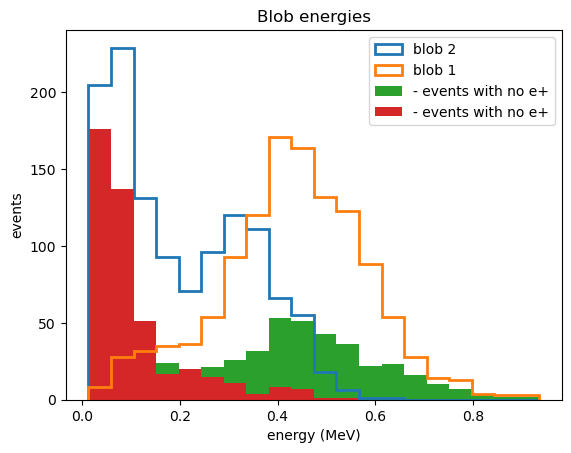

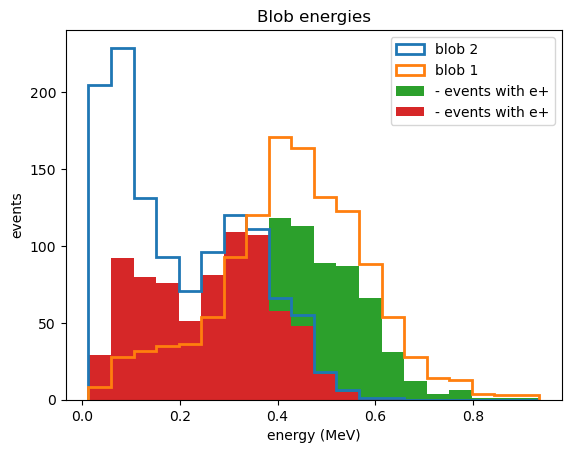

In [45]:

these_bins = 20
# the original way
plot_hist(ecut_rel, column = 'eblob2', binning = these_bins, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plot_hist(ecut_rel, column = 'eblob1', binning = these_bins, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

#plt.hist(no_pos_blob1, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))
#plt.hist(no_pos_blob2, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))

plot_hist(ecut_no_positron_df, column = 'eblob1', binning = these_bins, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plot_hist(ecut_no_positron_df, column = 'eblob2', binning = these_bins, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

plt.legend()
plt.show()

# the original way
plot_hist(ecut_rel, column = 'eblob2', binning = these_bins, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plot_hist(ecut_rel, column = 'eblob1', binning = these_bins, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

#plt.hist(no_pos_blob1, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))
#plt.hist(no_pos_blob2, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))

plot_hist(ecut_positron_df, column = 'eblob1', binning = these_bins, title = "Blob energies", output = False, fill = True, label = '- events with e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plot_hist(ecut_positron_df, column = 'eblob2', binning = these_bins, title = "Blob energies", output = False, fill = True, label = '- events with e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

plt.legend()
plt.show()

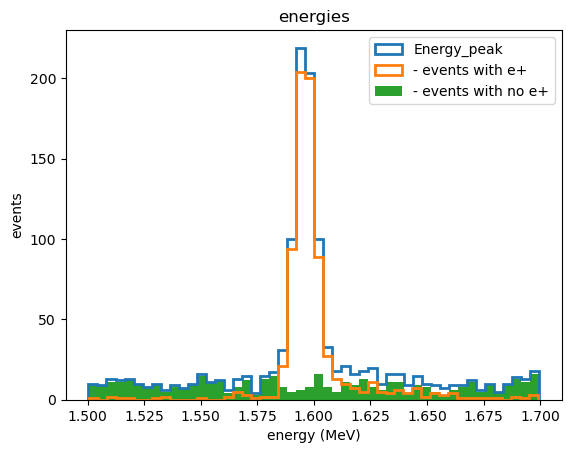

In [46]:
plot_hist(ecut_rel, column = 'energy', binning = 50, title = "energies", output = False, fill = False, label = 'Energy_peak', x_label = 'energy (MeV)')
plot_hist(ecut_positron_df, column = 'energy', binning = 50, title = "energies", output = False, fill = False, label = '- events with e+', x_label = 'energy (MeV)')
plot_hist(ecut_no_positron_df, column = 'energy', binning = 50, title = "energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)')

plt.legend()
plt.show()

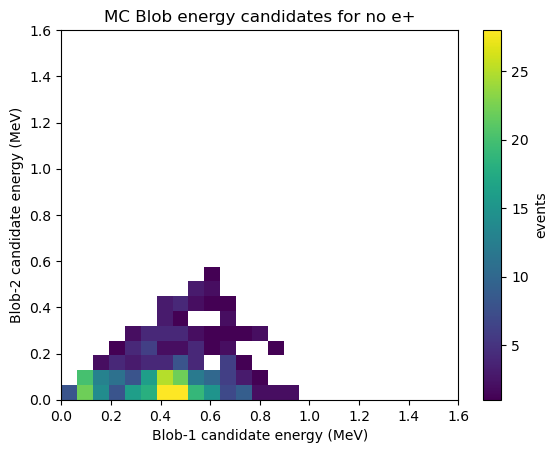

In [47]:
# plot the 2d histogram of blob energies for no positron data
# blob 2dhist
plt.hist2d(ecut_no_positron_df['eblob1'], ecut_no_positron_df['eblob2'], bins=(25, 25), range=((0, 1.6), (0, 1.6)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (MeV)")
plt.ylabel("Blob-2 candidate energy (MeV)")
plt.title("MC Blob energy candidates for no e+")
plt.show()

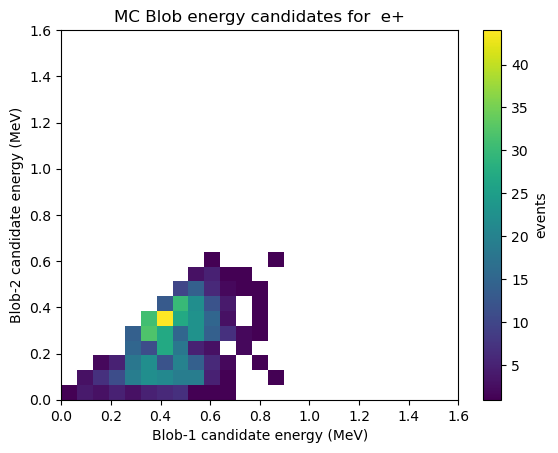

In [68]:
# plot the 2d histogram of blob energies for no positron data
# blob 2dhist
plt.hist2d(ecut_positron_df['eblob1'], ecut_positron_df['eblob2'], bins=(25, 25), range=((0, 1.6), (0, 1.6)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (MeV)")
plt.ylabel("Blob-2 candidate energy (MeV)")
plt.title("MC Blob energy candidates for  e+")
plt.show()

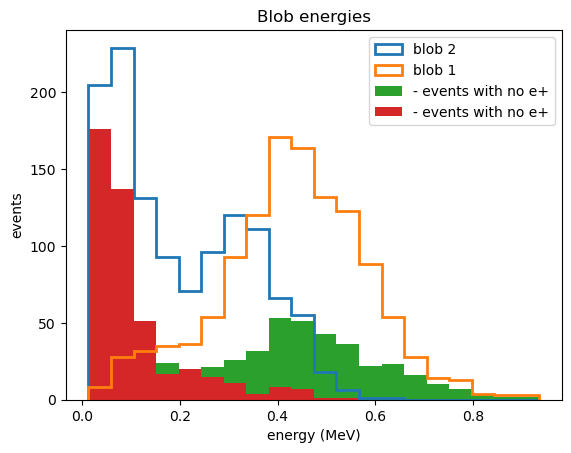

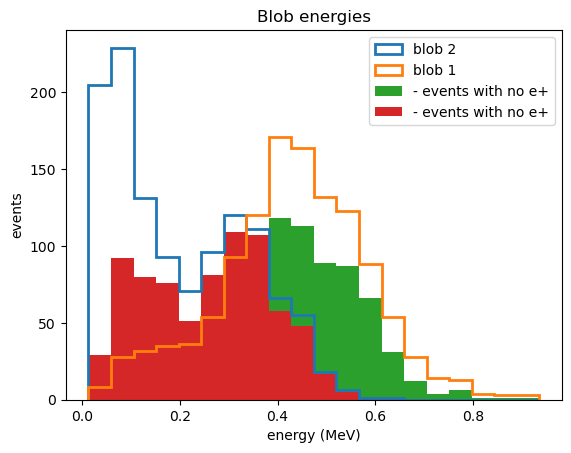

In [48]:
def blob_positron_plot(ecut_rel, ecut_no_positron_df, save = False, save_title = 'plot.png'):
    '''
    Plots the blob energies with and without positrons.
    '''

    # the original way
    plot_hist(ecut_rel, column = 'eblob2', binning = 20, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
    plot_hist(ecut_rel, column = 'eblob1', binning = 20, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

    #plt.hist(no_pos_blob1, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))
    #plt.hist(no_pos_blob2, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))

    plot_hist(ecut_no_positron_df, column = 'eblob1', binning = 20, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
    plot_hist(ecut_no_positron_df, column = 'eblob2', binning = 20, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

    plt.legend()

    if (save == True):
        plt.savefig(save_title)
    plt.show()

blob_positron_plot(ecut_rel, ecut_no_positron_df)
blob_positron_plot(ecut_rel, ecut_positron_df)

# Now to readadapt the code to give true FOM from sig and background while adjusting the cut location.

In [37]:


def true_fom_calc(p_data, no_p_data, cut_list, verbose = False):
    '''
    produces a figure of merit list based
    on cuts to specific categories and their
    consequent fits

    '''

    # create deep copies for safety
    pos_data = p_data.copy(deep = True)
    no_pos_data = no_p_data.copy(deep = True)

    if (verbose == True):
        blob_positron_plot(pos_data, no_pos_data)
    # Take the initial, no blob2 cut values for ns and nb
    ns0 = len(pos_data.index)
    nb0 = len(no_pos_data.index)
    # create all the lists for fom
    e = []
    b = []
    fom = []

    for i in range(len(cut_list)):
        
        # remove blob 2 values below value on cut_list
        pos_data = pos_data[(pos_data['eblob2'] > cut_list[i])]
        no_pos_data = no_pos_data[(no_pos_data['eblob2'] > cut_list[i])]


        # apply fit to the new data 
        if (verbose == True):
            print("Signal events: {}\nBackground events: {}\n FOM: {}".format())
        
        # collect number of signal events vs number of backgrounds, which you know 
        ns = len(pos_data.index)
        nb = len(no_pos_data.index)

        # produce fom value
        e.append(ns/ns0)
        b.append(nb/nb0)
        fom.append(e[i]/np.sqrt(b[i]))

        if (verbose == True):
            blob_positron_plot(pos_data, no_pos_data)
        
    # that should be it? i dont expect this to work first time, but lets test it!
    return fom

In [38]:
cut_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
fom = true_fom_calc(ecut_positron_df, ecut_no_positron_df, cut_list)

/tmp/ipykernel_7841/496507008.py:41: RuntimeWarning: divide by zero encountered in double_scalars
  fom.append(e[i]/np.sqrt(b[i]))


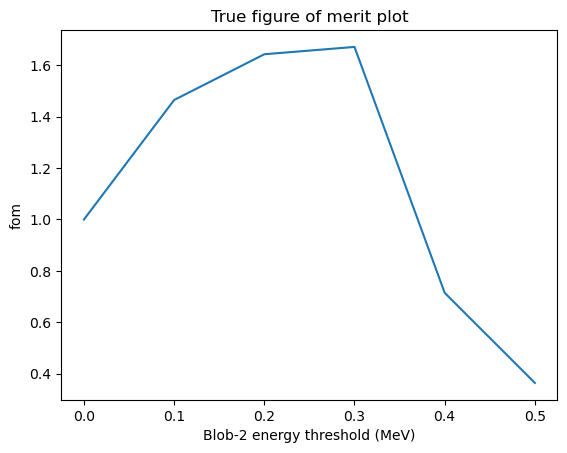

In [39]:
# plot fom
plt.plot(cut_list, fom)
plt.title("True figure of merit plot")
plt.xlabel("Blob-2 energy threshold (MeV)")
plt.ylabel("fom")
plt.show()

### Lets try a more aggressive cut around the peak to reduce FOM?

In [40]:
ecut_slim = energy_cuts(ecut_rel, lower_e = 1.575, upper_e = 1.625)


In [41]:
# create e+ dataframe only
positron_df_slim = pd.DataFrame(columns=particles.columns)

condition = (particles['particle_name'] == 'e+')
positron_events_slim = positron_df.append(particles.loc[condition], ignore_index=True)
print("True events with positrons:")
display(positron_events_slim.head(20))

# collect events
pos_events_slim = np.unique(positron_events_slim['event_id'].to_numpy())
print("Total number of positron events: {}".format(len(pos_events_slim)))
#print(pos_events)


# collect all events that dont match this list
ecut_no_positron_df_slim = ecut_slim[~ecut_slim['event'].isin(pos_events_slim)]

print("Isaura events with no positrons")
display(ecut_no_positron_df_slim.head(20))

# events with positrons only in here!
ecut_positron_df_slim = ecut_slim[ecut_slim['event'].isin(pos_events_slim)]

print("Isaura events with positrons:")
display(ecut_positron_df_slim.head(20))

# Check that we get all the data, should print true (which it does) 
print("Isaura events total: {}\nPositron Events: {}\nNon-positron events: {}\nDoes this add up? {}".format(len(ecut_slim),len(ecut_positron_df_slim), len(ecut_no_positron_df_slim), len(ecut_positron_df_slim) + len(ecut_no_positron_df_slim) == len(ecut_slim)))
print()



True events with positrons:


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,5080008,42,e+,False,40,399.615417,394.366058,536.815430,0.004905,399.746094,...,0.780250,0.557767,1.590467,-0.0,-0.0,0.0,1.415293,1.324204,conv,annihil
1,5080032,32,e+,False,30,-166.862320,-370.026581,1148.358154,3.770954,-198.535721,...,-0.247377,-0.461457,1.173200,0.0,0.0,-0.0,0.871628,187.018860,conv,annihil
2,5080036,37,e+,False,35,-65.955795,324.198029,272.437469,1.781441,-22.099428,...,-1.258216,-0.110806,-0.581811,0.0,-0.0,0.0,0.970557,263.940033,conv,annihil
3,5080048,18,e+,False,16,394.422913,407.527100,535.740845,0.035130,394.485077,...,0.217861,0.929769,-0.199142,0.0,-0.0,0.0,0.590233,0.248721,conv,annihil
4,5080050,43,e+,False,41,466.010071,219.144073,487.874298,0.656721,466.172241,...,0.595691,-1.389832,-0.308319,0.0,0.0,0.0,1.114628,0.823723,conv,annihil
5,5080066,40,e+,False,38,427.781158,377.352051,442.963135,0.340736,428.130005,...,0.537648,-0.716717,-1.240047,-0.0,0.0,-0.0,1.101944,0.871644,conv,annihil
6,5080080,46,e+,False,38,426.655273,364.533203,592.671570,0.232653,426.677277,...,0.462149,-0.210924,0.238228,-0.0,0.0,-0.0,0.247910,0.071758,conv,annihil
7,5080136,39,e+,False,37,477.058289,-86.245613,347.050385,1.740581,374.990082,...,-1.460626,-0.183496,0.252609,0.0,-0.0,0.0,1.067617,277.627106,conv,annihil
8,5080138,38,e+,False,36,-63.345615,-213.545135,977.998840,2.941550,-61.490604,...,0.078129,-0.363009,0.665113,-0.0,-0.0,-0.0,0.406266,69.172440,conv,annihil
9,5080172,52,e+,False,50,-32.611187,216.488098,1540.216064,3.699887,-32.628563,...,-0.335066,0.032621,0.565033,0.0,0.0,0.0,0.321897,0.147108,conv,annihil


Total number of positron events: 13282
Isaura events with no positrons


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
3702,1140630,0,1.581736,273.332373,216,12999,1,242.675,-28.325,584.348755,...,675.480459,329.054850,169.358805,592.509623,0.205684,0.093228,0.0,9.400000,9.708333,4.968898
5308,80494,0,1.582480,330.954116,199,11468,1,-171.325,191.675,361.742035,...,413.814469,13.569987,300.847950,399.401761,0.539764,0.060859,0.0,9.843750,9.727273,4.851889
7364,1560084,0,1.607787,276.867071,215,12368,1,-132.325,158.675,31.159515,...,33.029529,-73.451906,319.656001,68.769089,0.344663,0.101011,0.0,9.333333,9.500000,4.707685
7934,1560468,0,1.586793,69.176471,100,12444,1,181.675,28.675,1021.142090,...,1034.278145,210.488624,102.311044,1034.756226,0.466340,0.063437,0.0,9.687500,9.882353,4.959872
9007,3840588,0,1.597800,295.143930,196,11204,1,201.675,219.675,525.563904,...,529.151251,247.175782,360.162801,551.041469,0.720690,0.062540,0.0,10.000000,9.588235,4.913275
9571,2720320,0,1.576866,115.016937,191,12312,1,239.675,-4.325,534.972046,...,602.032230,271.295506,8.481978,538.131968,0.471938,0.114999,0.0,9.444444,9.375000,4.971651
9583,2720332,0,1.602028,215.433404,191,10720,1,12.675,96.675,358.611816,...,401.432886,194.653114,131.897324,372.217163,0.393404,0.023493,0.0,9.772727,9.857143,4.997063
11582,2020414,0,1.592122,337.983071,207,12713,1,88.675,-254.325,111.903679,...,114.836720,205.130275,-34.115902,240.514659,0.511429,0.075421,0.0,9.923077,9.826087,4.971935
16673,3560146,0,1.576628,267.177605,236,13134,1,-198.325,-85.325,558.077087,...,561.977786,-47.508195,83.454503,633.809888,0.102173,0.066704,0.0,9.578947,9.666667,4.752438
17958,2520328,0,1.596208,273.954956,237,12720,1,144.675,300.675,119.247154,...,145.526425,198.949347,405.186559,203.679077,0.412922,0.035296,0.0,9.750000,9.466667,4.909763


Isaura events with positrons:


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
267,5080188,0,1.596243,148.610599,166,12026,1,156.675,107.675,734.490601,...,790.273825,249.822411,184.883484,737.356621,0.504019,0.225764,0.0,10.000000,9.333333,4.796073
716,5080496,0,1.594183,145.284581,182,12653,1,147.675,-166.325,322.920868,...,330.867496,230.952113,-81.031343,348.966834,0.453787,0.448485,0.0,9.533333,9.200000,4.765714
732,5080512,0,1.598140,93.341661,134,13380,1,199.675,202.675,571.753174,...,575.643930,243.150771,217.771735,624.821370,0.597386,0.274505,0.0,9.333333,9.875000,4.717321
788,5080546,0,1.624835,142.198792,192,13082,1,274.675,205.675,601.143860,...,654.743361,279.786145,278.917336,602.637710,0.459660,0.048675,0.0,9.700000,9.416667,4.841694
833,5080582,0,1.595847,146.944952,213,12321,1,293.675,-51.325,683.036133,...,727.546243,342.440444,56.530423,705.270434,0.309328,0.172304,0.0,9.272727,9.615385,4.672752
922,5080668,0,1.592118,121.172948,132,11396,1,-47.325,148.675,665.186584,...,742.493230,-36.165789,172.935768,671.769838,0.567643,0.460469,0.0,9.125000,9.500000,4.998995
931,5080676,0,1.594673,132.306971,173,12554,1,175.675,150.675,453.089264,...,459.321732,273.448556,157.385258,497.192617,0.629942,0.344451,0.0,9.416667,10.000000,4.646007
1047,1740022,0,1.595029,269.726773,201,12142,1,186.675,-40.325,405.846893,...,503.153273,201.867704,58.954131,414.758418,0.489247,0.421876,0.0,10.000000,9.333333,4.983875
1741,1740504,0,1.607631,137.948080,198,11946,1,385.675,-119.325,325.017609,...,333.456278,443.320490,-77.306432,416.737771,0.568997,0.105663,0.0,9.125000,9.625000,4.968434
2153,3580184,0,1.596952,252.441306,189,12593,1,87.675,286.675,153.902756,...,213.828495,219.017976,291.696169,187.412628,0.496536,0.445881,0.0,9.857143,9.714286,4.863352


Isaura events total: 799
Positron Events: 679
Non-positron events: 120
Does this add up? True



In [42]:
cut_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
fom_slim = true_fom_calc(ecut_positron_df_slim, ecut_no_positron_df_slim, cut_list)

/tmp/ipykernel_7841/496507008.py:41: RuntimeWarning: divide by zero encountered in double_scalars
  fom.append(e[i]/np.sqrt(b[i]))
/tmp/ipykernel_7841/496507008.py:41: RuntimeWarning: invalid value encountered in double_scalars
  fom.append(e[i]/np.sqrt(b[i]))


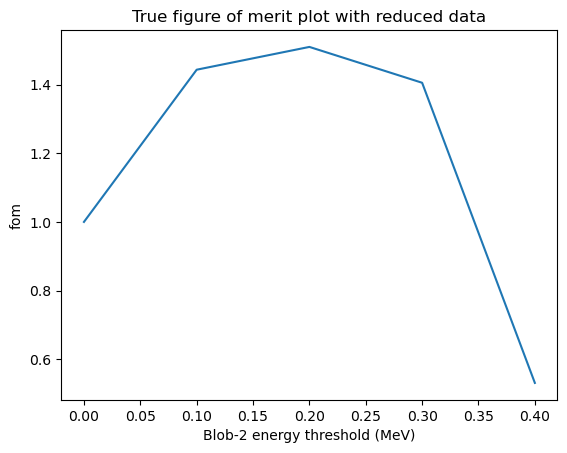

In [43]:
# plot fom
plt.plot(cut_list, fom_slim)
plt.title("True figure of merit plot with reduced data")
plt.xlabel("Blob-2 energy threshold (MeV)")
plt.ylabel("fom")
plt.show()

Reducing the range makes it worse. Should have expected this in all honesty...

### Applying fitting

In [365]:
# lets try this ourselves

def bck_func(x, nb, tau):
    '''
    Function describing the background, an exponential with scaling from Nb and tau
    '''

    return nb*np.exp(-x/tau)



def skewnorm_func(x, a, mu, sigma):
    return skewnorm.pdf(x, a, loc = mu, scale = sigma)



def error_func(x, mu, sigma):
    pas = (x - mu)/(np.sqrt(2)*sigma)
    return special.erfc(pas)



def sig_func(x, ns, a, mu, sigma, C1, C2):
    
    return ns * (skewnorm_func(x, a, mu, sigma) + C1*error_func(x, mu, sigma) + C2)



def sig_bck_func(x, ns, a, mu, sigma, C1, C2, nb, tau):

    return bck_func(x, nb, tau) + sig_func(x, ns, a, mu, sigma, C1, C2)


# create gaussian initially for testing purposes
def gauss(x, a, mu, sigma):
    numer = np.square(x - mu)
    denom = 2*np.square(sigma)

    return a*np.exp(-numer/denom)


def gauss_norm(x, a, mu, sigma):
    numer = np.square(x - mu)
    denom = 2*np.square(sigma)
    norm = (np.sqrt(2*np.pi) * sigma)


    return (a*np.exp(-numer/denom))/ norm

def gauss_bck_norm(x, a, mu, sigma, C):
    numer = np.square(x - mu)
    denom = 2*np.square(sigma)
    norm = (np.sqrt(2*np.pi) * sigma)

    return (a*np.exp(-numer/denom) / norm) + C    


def bck(x, C):
    return np.full_like(x, C)

def gauss_bck(x, a, mu, sigma, C):
    numer = np.square(x - mu)
    denom = 2*np.square(sigma)


    return a*np.exp(-numer/denom) + C

# and a print function
def print_parameters(popt,pcov,labels):
    '''
    Prints fitting parameters

    :param popt:        Fit parameters
    :param pcov:        Fit covariances
    :param labels:      Labels of parameters
    '''
    print('===============================')
    print("        Fitting output      ")
    print('===============================')
    for i in range(len(popt)):
        print("{}: {:.4f} \u00B1 {:.4f}".format(labels[i], popt[i], np.sqrt(pcov[i][i]) )) # taking diagonal covariances as errors
    print('===============================')
    return 0

 
# plot parameters for fit, similar to plot_hist
def plot_fit(function, x, popt, popt_label, output = False, colour = 'red', x_counts = 100000, lgnd = 'Fit', popt_text = True):
    '''
    plots a fit based on individual points and a function
    plots across a more continuous space, to reduce weird artifacting for low X numbers
    '''

    # take much more continuous x axis
    x_min = np.min(x)
    x_max = np.max(x)

    x_plot = np.linspace(x_min, x_max, num = x_counts, endpoint = True)

    y = function(x_plot, *popt)
    plt.plot(x_plot, y, label = lgnd, color = colour)
    
    # create locations to put the text relative to the scale of the figure
    percentage_hor = 0.01
    percentage_vert = 0.95
    x_loc = np.min(x) + (np.max(x) - np.min(x))*percentage_hor
    y_loc = np.min(y) + (np.max(y) - np.min(y))*percentage_vert
    # reasonable gap for separation, based on scale
    gap = (np.max(y) - np.min(y)) * 0.05

    if (popt_text == False):
        for i in range(len(popt)):

            plt.text(x_loc, y_loc - gap*i, str(popt_label[i]) + ": " + str(round(popt[i], 5)), verticalalignment='top', horizontalalignment='left')

    if (output == True):
        plt.show()
    else:
        return


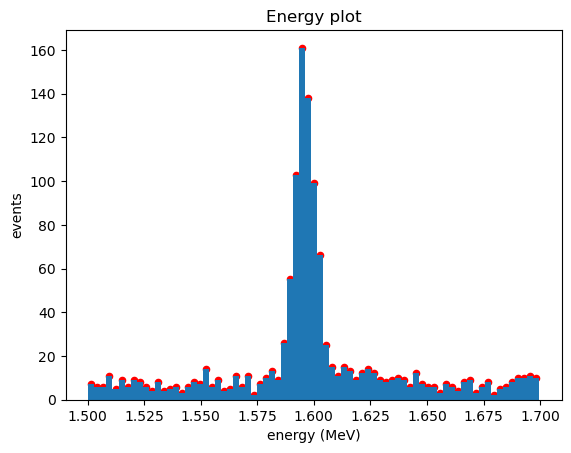

In [347]:
# try fitting gaussian
evalues = ecut_rel['energy'].to_numpy()

e_low = np.min(evalues) 
e_high = np.max(evalues)

# collect heights from histogram of energy
hist, edges, patches = plot_hist(ecut_rel, binning = 75, output = False, data = True)
# convert edges to centres
centres = shift_to_bin_centers(edges)

plt.scatter(centres, hist, color='red', s = 20)
plt.show()

In [348]:
# fit gaussian to this

# p0 is the initial guesses
p0 = ([800, 1.58, 0.04])
gauss_labels = ['a', 'mu','sigma']

popt, pcov = curve_fit(gauss, centres, hist, p0, maxfev = 500000)

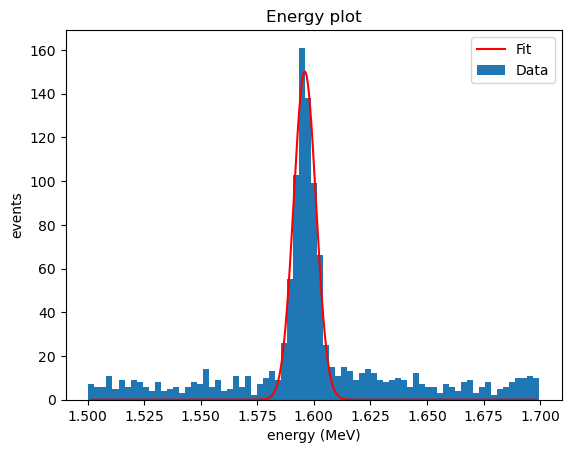

[1.50089965e+02 1.59599004e+00 4.91900997e-03]
(1.850628699212603, 3.812286680036762e-09)
        Fitting output      
a: 150.0900 ± 5.6162
mu: 1.5960 ± 0.0002
sigma: 0.0049 ± 0.0002


In [349]:
plot_fit(gauss, centres, popt, gauss_labels)
plot_hist(ecut_rel, binning = 75, output = False, data = True, label='Data')
plt.legend()
plt.show()

print(popt)
print(quad(gauss, emin, emax, args = (popt[0], popt[1], popt[2])))

nothing = print_parameters(popt, pcov, gauss_labels)
del nothing

#### Try fitting it all now

In [350]:
# fit full thing to this

# ns -> take as fraction of peak. Example: peak at 1000 events, ns at 1000*8

# p0 is the initial guesses
p1 = ([5, -2.8, 1.6, 0.006, 0.05, 0.0001, 10, 300])
big_labels = ['ns', 'a', 'mu', 'sigma', 'C1', 'C2', 'nb', 'tau']

popt, pcov = curve_fit(sig_bck_func, centres, hist, p1, maxfev = 500000)

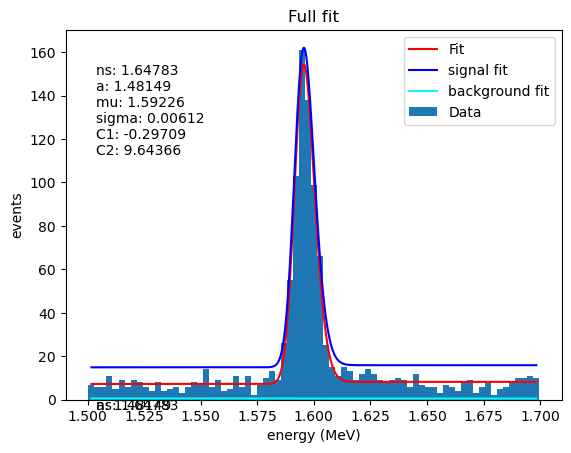

        Fitting output      
ns: 1.6478 ± 0.0720
a: 1.4815 ± 0.2497
mu: 1.5923 ± 0.0003
sigma: 0.0061 ± 0.0003
C1: -0.2971 ± 0.5846
C2: 9.6437 ± 41690211.0005
nb: -7.6698 ± 68698362.4394
tau: 1935581.1834 ± 12651495474381.1074


0

In [351]:
plot_fit(sig_bck_func, centres, popt, big_labels)
plot_fit(sig_func, centres, popt[:-2], big_labels[:-2], lgnd='signal fit', colour = 'blue', popt_text = False)
plot_fit(bck_func, centres, popt[:2], big_labels[:2], lgnd='background fit', colour = 'cyan', popt_text = False)
plot_hist(ecut_rel, binning = 75, output = False, data = True, label='Data', title='Full fit')
plt.legend()
plt.show()
print_parameters(popt, pcov, big_labels)



#### Cut @ 0.2 MeV for blob 2 and see how the fit looks

In [352]:
ecut_200keV = ecut_rel[(ecut_rel['eblob2'] > 0.2)]


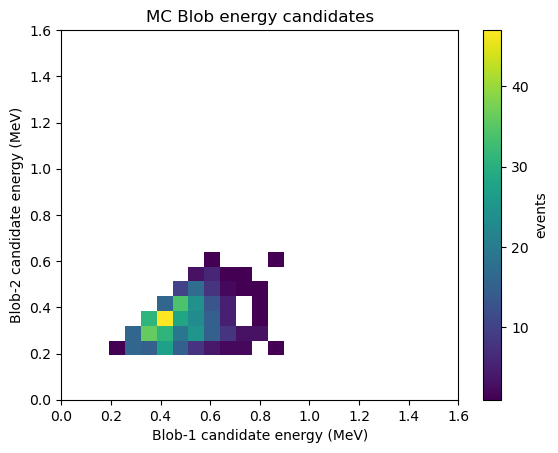

In [353]:
plt.hist2d(ecut_200keV['eblob1'], ecut_200keV['eblob2'], bins=(25, 25), range=((0, 1.6), (0, 1.6)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (MeV)")
plt.ylabel("Blob-2 candidate energy (MeV)")
plt.title("MC Blob energy candidates")
plt.show()

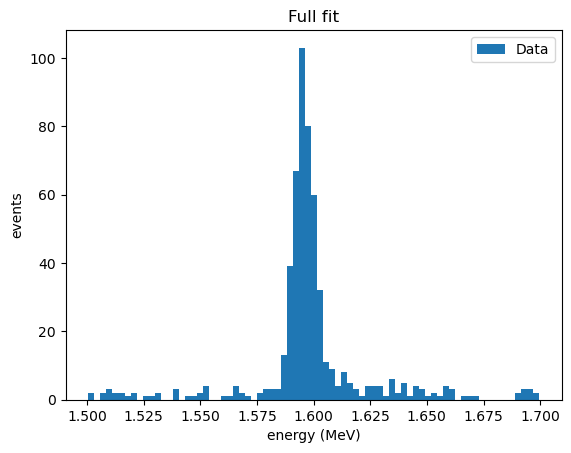

In [354]:
plot_hist(ecut_200keV, binning = 75, output = False, data = True, label='Data', title='Full fit')
plt.legend()
plt.show()

### trying gauss with basic background, and then a FOM for this up to 0.2 MeV

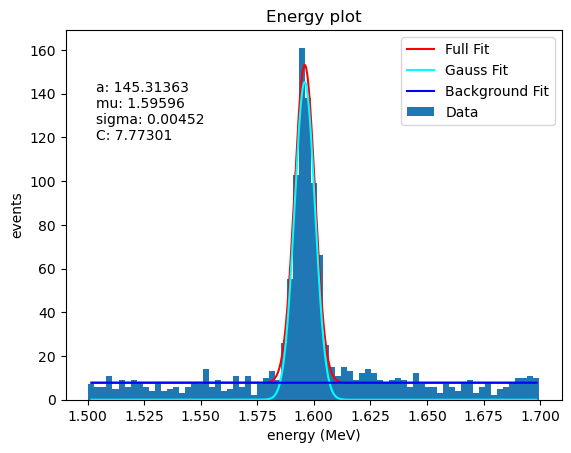

        Fitting output      
a: 145.3136 ± 2.6925
mu: 1.5960 ± 0.0001
sigma: 0.0045 ± 0.0001
C: 7.7730 ± 0.4667
ns = 620.0244691227318
nb = 585.173534239253
total = 1205.1980033619848


In [375]:
# first, lets try fitting it
p0 = [1, 1.58, 0.006, 5]
gauss_bck_labels = ['a', 'mu', 'sigma', 'C']

popt, pcov = curve_fit(gauss_bck, centres, hist, p0, maxfev = 5000000)

plot_fit(gauss_bck, centres, popt, gauss_bck_labels, lgnd='Full Fit', colour = 'red', popt_text = False)
plot_fit(gauss, centres, popt[:-1], gauss_bck_labels[:-1], lgnd = 'Gauss Fit', colour = 'cyan', popt_text = True)
plot_fit(bck, centres, [popt[-1]], gauss_bck_labels[-1], lgnd = 'Background Fit', colour = 'blue', popt_text = True)
plot_hist(ecut_rel, binning = 75, output = False, data = True, label='Data')
plt.legend()
plt.show()
print_parameters(popt, pcov, gauss_bck_labels)

bin_width = centres[1] - centres[0]

x_points = np.linspace(emin, emax, 100000)

ns0 = quad(gauss, emin, emax, args = (popt[0], popt[1], popt[2]))/bin_width
nb0 = quad(bck, emin, emax, args = popt[-1])/bin_width
print('ns = {}'.format(ns0[0]))
print('nb = {}'.format(nb0[0]))
print("total = {}".format(ns0[0]+nb0[0]))

In [380]:
len(ecut_rel)

1203

### So we can see from above that this works as expected (get approximately the same number of events as we wish)

In [211]:
# integrate over these functions now

print(list(popt[:-1]))
ns0 = quad(gauss, emin, emax, args = tuple(popt[:-1]))
nb0 = quad(bck, emin, emax, args = popt[-1])

print(ns0)
print(nb0)

[145.31363216630734, 1.595963619610449, 0.004522170372240588]
(1.6471881631696366, 5.142984170643499e-09)
(1.5546014181711922, 1.7259542885685788e-14)


### Re-using old code to apply FOM cuts here

In [384]:
def default_fit(data, bins = 75, verbose = False):
    '''
    Apply the expected fit to the data here,
    '''

    # find minima and maxima
    evalues = data['energy'].to_numpy()
    e_low = np.min(evalues) 
    e_high = np.max(evalues)

    # collect heights from histogram of energy
    hist, edges, patches = plot_hist(data, binning = bins, output = False, data = True)
    plt.clf()
    # convert edges to centres
    centres = shift_to_bin_centers(edges)


    # collect assumptions
    p1 = [1, 1.58, 0.006, 5]
    gauss_bck_labels = ['a', 'mu', 'sigma', 'C']

    # fit function
    popt, pcov = curve_fit(gauss_bck, centres, hist, p1, maxfev = 5000000)

    if (verbose == True):
        plot_fit(gauss_bck, centres, popt, gauss_bck_labels)
        plot_fit(gauss, centres, popt[:-1], gauss_bck_labels[:-1], lgnd = 'Gauss Fit', colour = 'cyan', popt_text = False)
        plot_fit(bck, centres, [popt[-1]], gauss_bck_labels[-1], lgnd = 'Background Fit', colour = 'blue', popt_text = True)
        
        plot_hist(data, binning = bins, output = False, data = True, label='Data')
        plt.legend()
        plt.show()
        print_parameters(popt, pcov, gauss_bck_labels)

    # centres passed through to ensure we get the correct even numbers
    return (popt, pcov, gauss_bck_labels, centres)
        



def fom_calc(data, cut_list, no_pos_data = pd.DataFrame({'A' : []}), binning = 75, verbose = False):
    '''
    produces a figure of merit list based
    on cuts to specific categories and their
    consequent fits

    no_pos_data related to data with no positrons in it (background).
    Useful to visualise for 
    '''

    if ((verbose == True) and not (no_pos_data.empty)):
        blob_positron_plot(data, no_pos_data)
    # Take the initial, no blob2 cut values for ns and nb
    output = default_fit(data, bins = binning, verbose = True)

    popt = output[0]
    pcov = output[1]
    gauss_bck_labels = output[2]
    centres = output[3]

    # take bin widths to calculate number of events
    bin_width = centres[1] - centres[0]

    # signal is integration of function over the space
    ns0 = quad(gauss, emin, emax, args = tuple(popt[:-1]))/bin_width
    nb0 = quad(bck, emin, emax, args = popt[-1])/bin_width

    if (verbose == True):
        print('ns0      = {}'.format(ns0[0]))
        print('nb0      = {}'.format(nb0[0]))
        print("total    = {:.0f}".format(ns0[0]+nb0[0]))
        print("Event no = {}".format(len(data.index)))


    # create all the lists for fom
    e = []
    b = []
    fom = []

    for i in range(len(cut_list)):
        print("")
        print("")
        print("")
        
        print("==========================")
        print("        CUT {} MeV       ".format(cut_list[i]))
        print("==========================")
        # remove blob 2 values below value on cut_list
        data = data[(data['eblob2'] > cut_list[i])]
        if not (no_pos_data.empty):
            no_pos_data = no_pos_data[(no_pos_data['eblob2'] > cut_list[i])]
        # apply fit to the new data 
        if (verbose == True):
            output = default_fit(data, bins = binning, verbose = True)
        else:
            output = default_fit(data, bins = binning, verbose = False)
        
        # collect values
        popt = output[0]
        pcov = output[1]
        gauss_bck_labels = output[2]
        centres = output[3]

        # take bin widths to calculate number of events
        bin_width = centres[1] - centres[0]

        # collect ns and nb
        ns = quad(gauss, emin, emax, args = tuple(popt[:-1]))/bin_width
        nb = quad(bck, emin, emax, args = popt[-1])/bin_width

        if (verbose == True):
            print('ns - {}'.format(ns[0]))
            print('nb - {}'.format(nb[0]))
            print("total = {:.0f}".format(ns[0]+nb[0]))
            print("Event no = {}".format(len(data.index)))
        # produce fom value (DISCREETLY NOW AS IT ISNT WORKING)
        e_check     = ns[0]/ns0[0]
        b_check     = nb[0]/nb0[0]
        fom_check   = e_check/np.sqrt(b_check)
        

        print('\ne_i: {}\nb_i: {}\nfom: {}'.format(e_check, b_check, fom_check))

        e.append(e_check)
        b.append(b_check)
        fom.append(fom_check)

        if ((verbose == True) and not (no_pos_data.empty)):
            blob_positron_plot(data, no_pos_data)
        
    # that should be it? i dont expect this to work first time, but lets test it!
    return fom






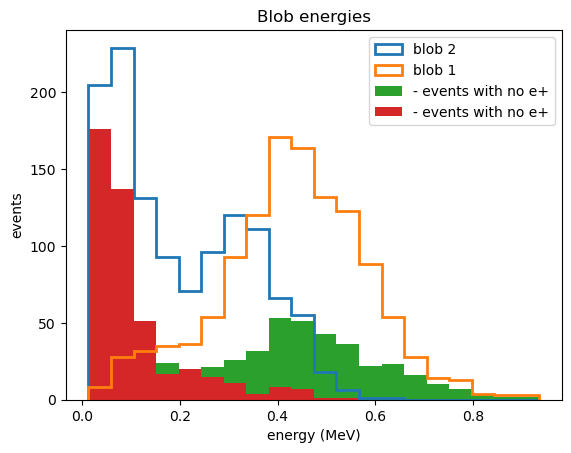

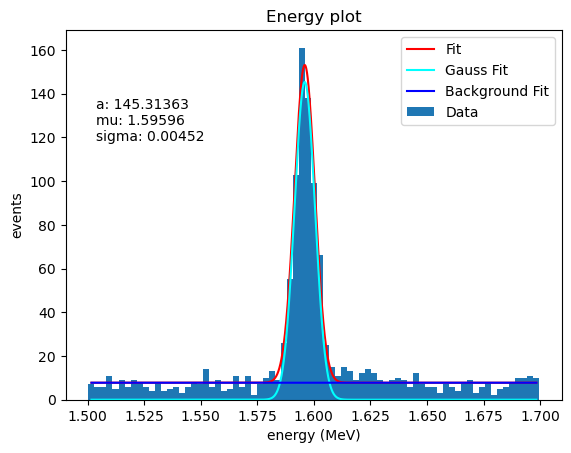

        Fitting output      
a: 145.3136 ± 2.6925
mu: 1.5960 ± 0.0001
sigma: 0.0045 ± 0.0001
C: 7.7730 ± 0.4667
ns0      = 620.0244691227318
nb0      = 585.173534239253
total    = 1205
Event no = 1203



        CUT 0 MeV       


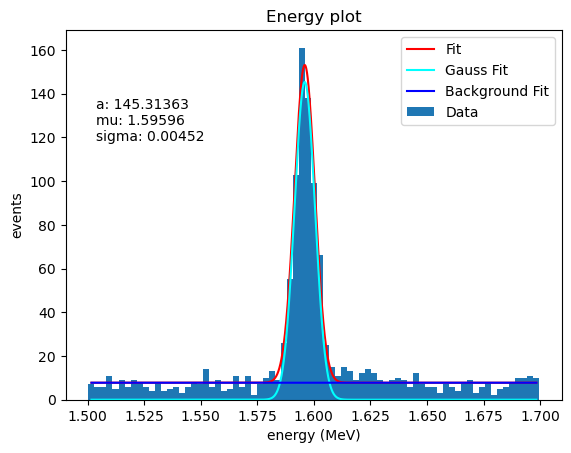

        Fitting output      
a: 145.3136 ± 2.6925
mu: 1.5960 ± 0.0001
sigma: 0.0045 ± 0.0001
C: 7.7730 ± 0.4667
ns - 620.0244691227318
nb - 585.173534239253
total = 1205
Event no = 1203

e_i: 1.0
b_i: 1.0
fom: 1.0


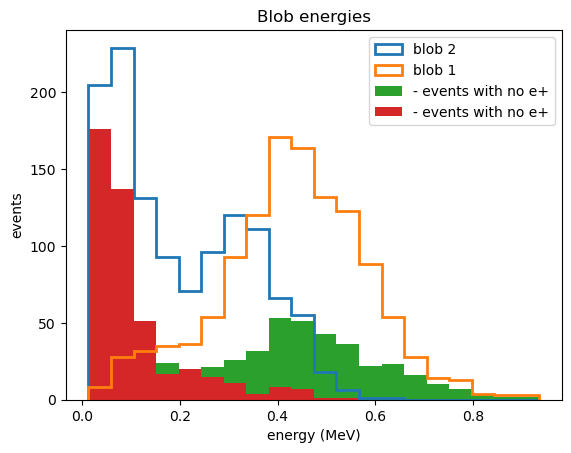




        CUT 0.05 MeV       


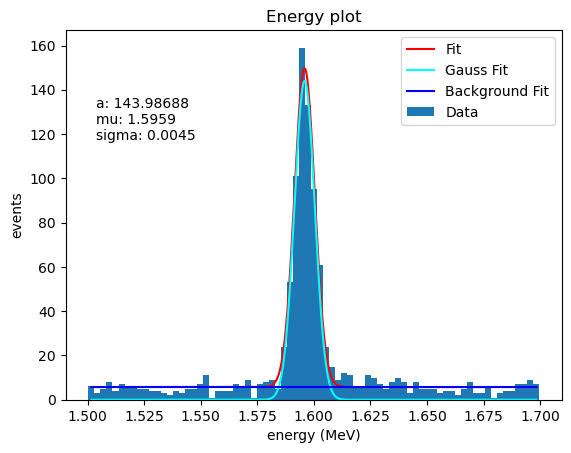

        Fitting output      
a: 143.9869 ± 2.5659
mu: 1.5959 ± 0.0001
sigma: 0.0045 ± 0.0001
C: 5.7364 ± 0.4437
ns - 611.7727249786452
nb - 431.8493673292416
total = 1044
Event no = 1042

e_i: 0.9866912604985382
b_i: 0.7379851310101739
fom: 1.14857001874251


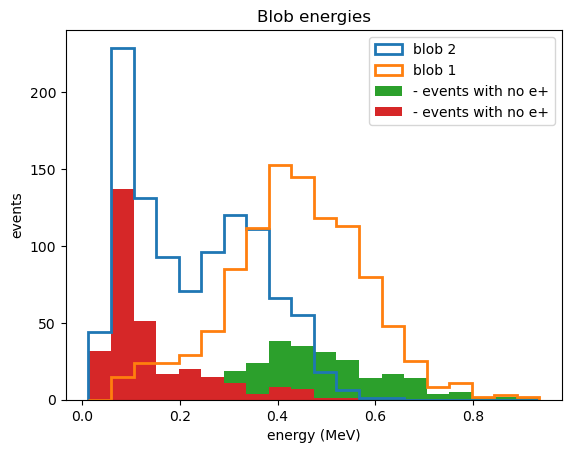




        CUT 0.1 MeV       


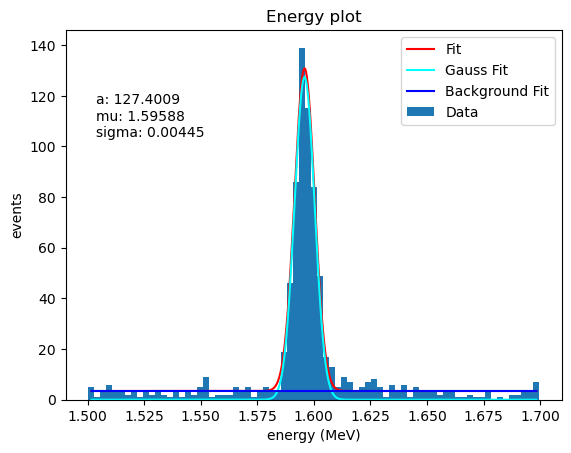

        Fitting output      
a: 127.4009 ± 2.1634
mu: 1.5959 ± 0.0001
sigma: 0.0044 ± 0.0001
C: 3.4434 ± 0.3715
ns - 534.7474467658162
nb - 259.22624714849826
total = 794
Event no = 793

e_i: 0.8624618436792124
b_i: 0.4429903814524043
fom: 1.2958142220447162


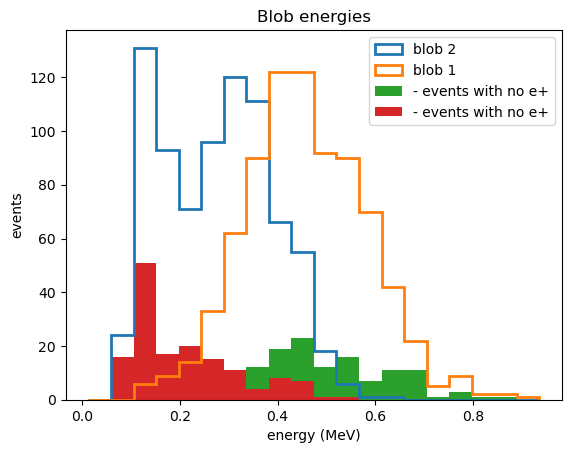




        CUT 0.15 MeV       


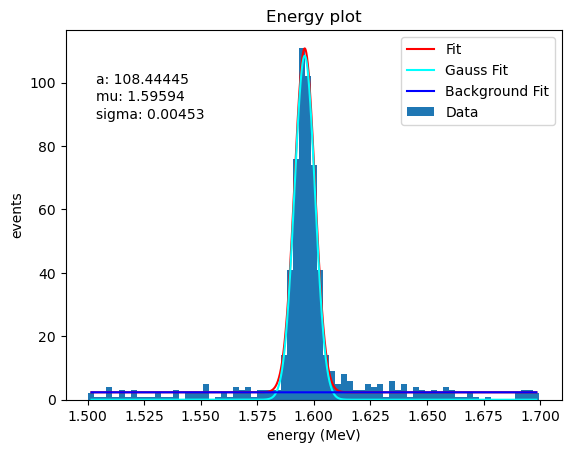

        Fitting output      
a: 108.4444 ± 1.3350
mu: 1.5959 ± 0.0001
sigma: 0.0045 ± 0.0001
C: 2.3396 ± 0.2316
ns - 463.5313437632602
nb - 176.13022897541916
total = 640
Event no = 639

e_i: 0.7476016945252296
b_i: 0.30098802948153647
fom: 1.3626855957067783


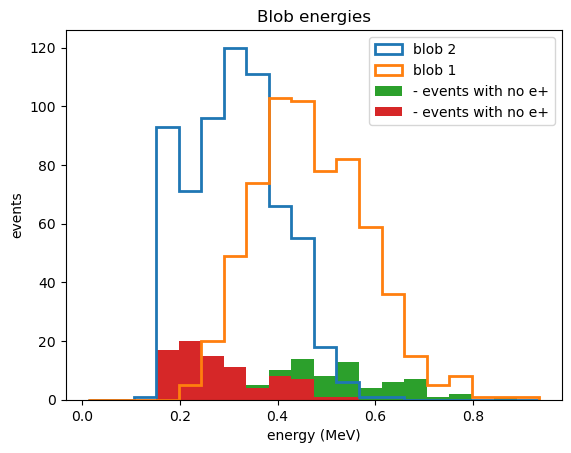




        CUT 0.2 MeV       


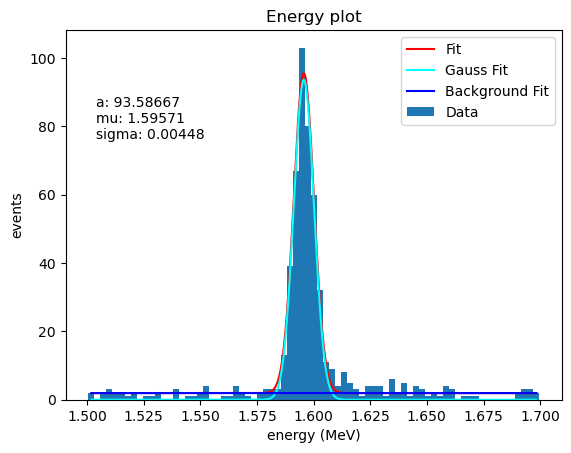

        Fitting output      
a: 93.5867 ± 1.6961
mu: 1.5957 ± 0.0001
sigma: 0.0045 ± 0.0001
C: 1.9426 ± 0.2927
ns - 396.30148752167327
nb - 146.44366071743104
total = 543
Event no = 542

e_i: 0.6391707218948913
b_i: 0.25025680785070564
fom: 1.2776853729616595


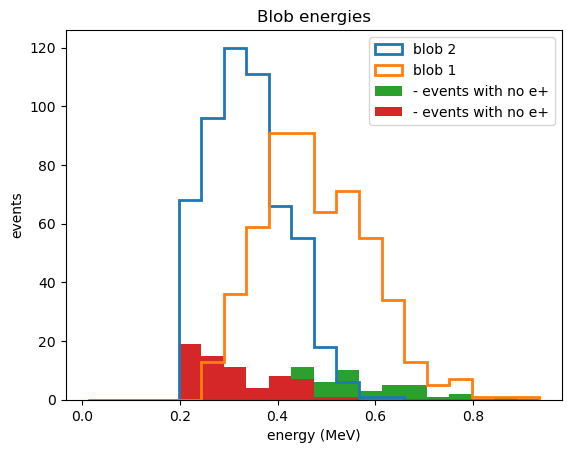

In [385]:
cut_list = [0, 0.05, 0.1, 0.15, 0.2]
fom = fom_calc(ecut_rel, cut_list, no_pos_data = ecut_no_positron_df, verbose = True)

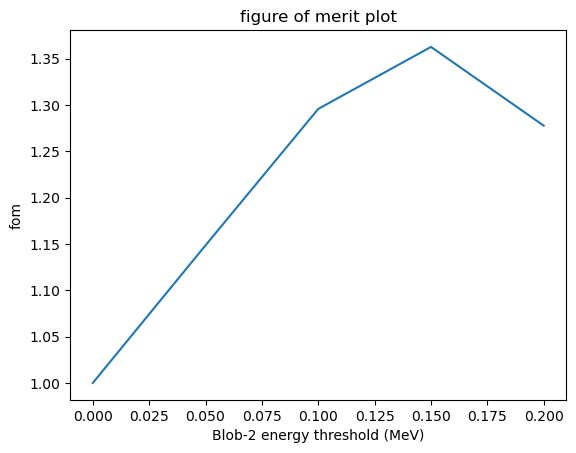

In [259]:
# plot fom
plt.plot(cut_list, fom)
plt.title("figure of merit plot")
plt.xlabel("Blob-2 energy threshold (MeV)")
plt.ylabel("fom")
plt.show()

#### trying smaller range of E values

In [319]:
print(len(slimmed_E.index))
# so there are only this number of events!

799


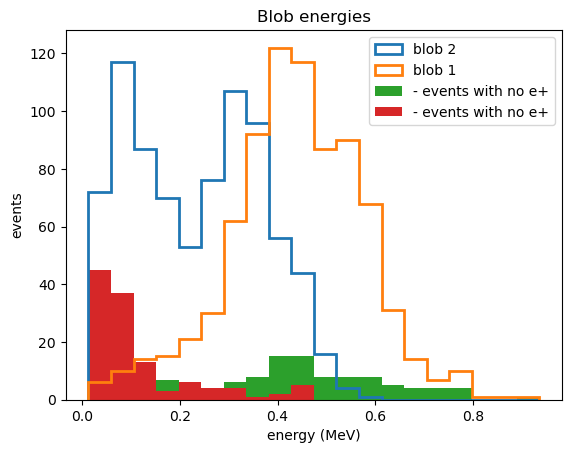

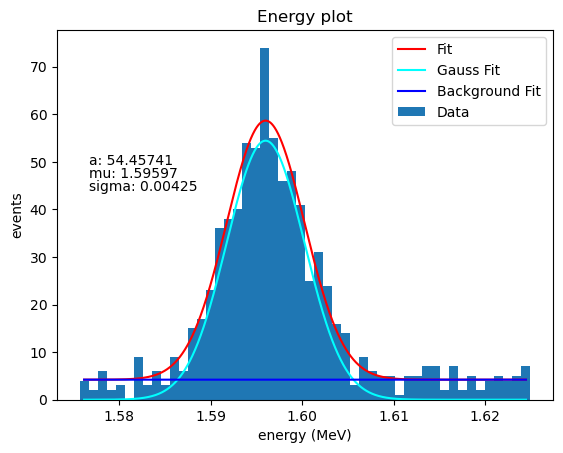

        Fitting output      
a: 54.4574 ± 1.7948
mu: 1.5960 ± 0.0002
sigma: 0.0042 ± 0.0002
C: 4.2174 ± 0.7439
ns0 - 588.1329434452939
nb0 - 855.625394136632



        CUT 0 MeV       


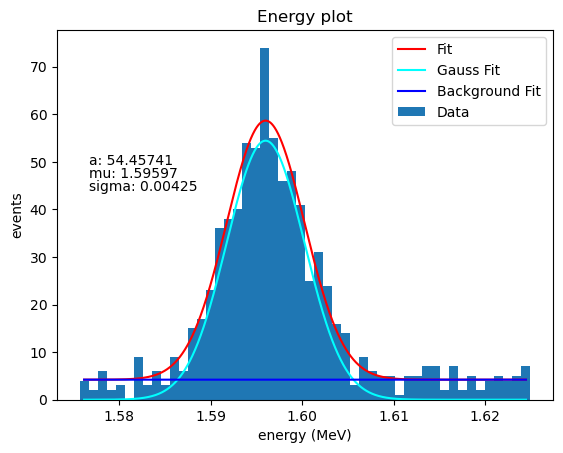

        Fitting output      
a: 54.4574 ± 1.7948
mu: 1.5960 ± 0.0002
sigma: 0.0042 ± 0.0002
C: 4.2174 ± 0.7439
ns - 588.1329434452939
nb - 855.625394136632

e_i: 1.0
b_i: 1.0
fom: 1.0


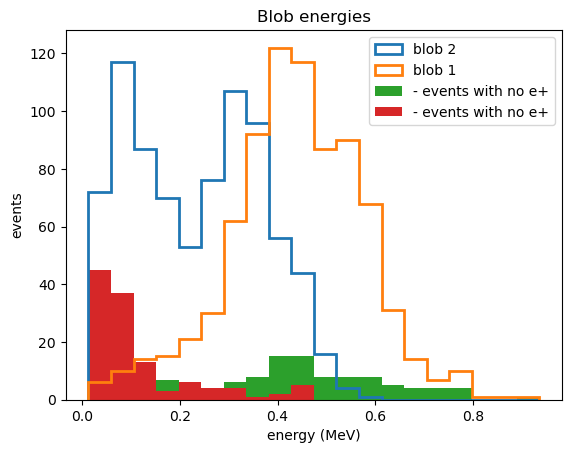




        CUT 0.05 MeV       


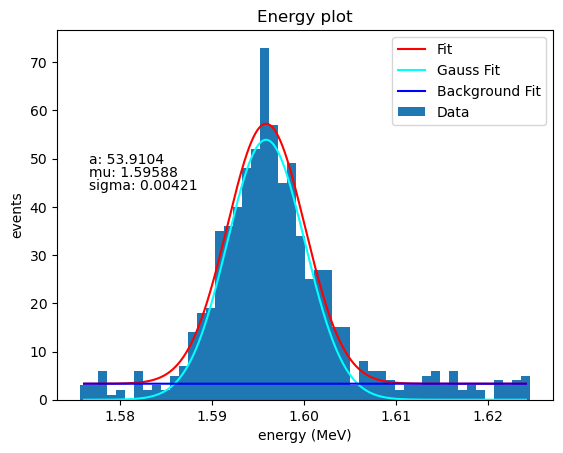

        Fitting output      
a: 53.9104 ± 1.8178
mu: 1.5959 ± 0.0002
sigma: 0.0042 ± 0.0002
C: 3.3226 ± 0.7519
ns - 580.8726949951243
nb - 679.01220245749

e_i: 0.9876554297270973
b_i: 0.793585846224967
fom: 1.1086858351592073


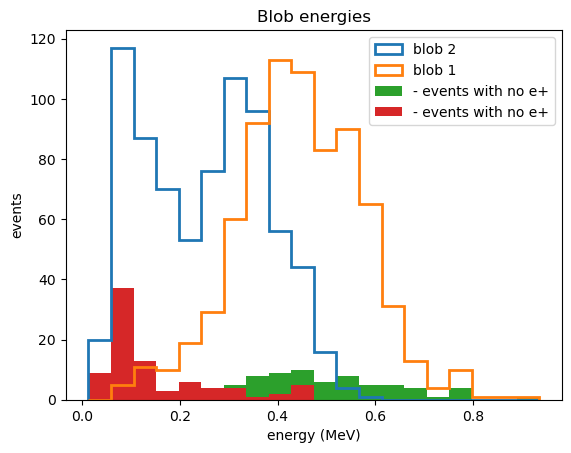




        CUT 0.1 MeV       


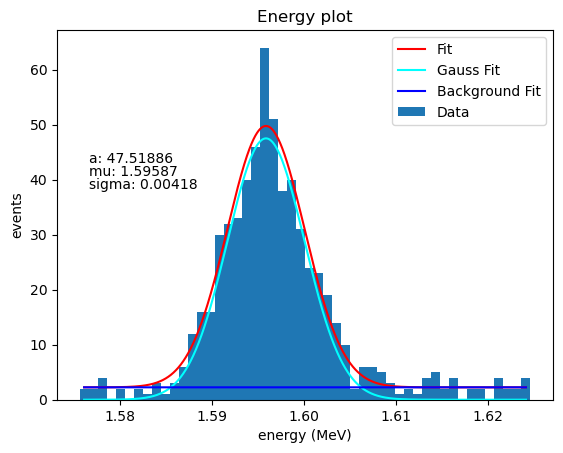

        Fitting output      
a: 47.5189 ± 1.5320
mu: 1.5959 ± 0.0001
sigma: 0.0042 ± 0.0002
C: 2.2541 ± 0.6309
ns - 509.29324888559387
nb - 460.66652123372046

e_i: 0.8659491949254609
b_i: 0.5383974393356518
fom: 1.180160079482056


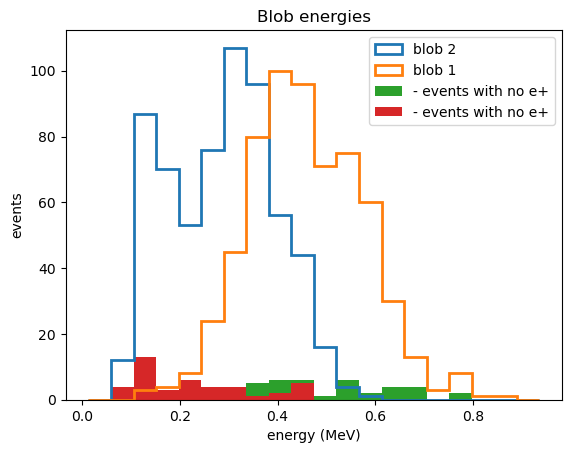




        CUT 0.15 MeV       


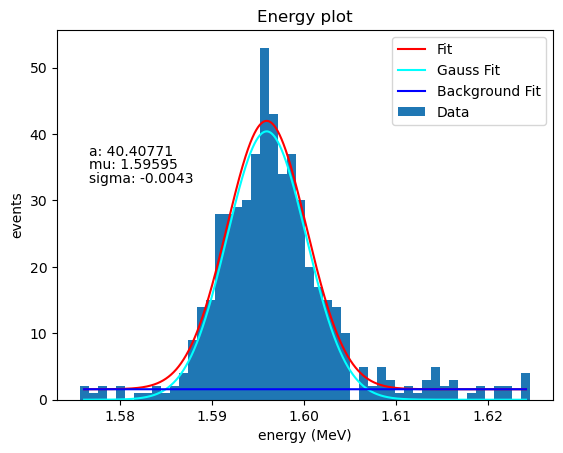

        Fitting output      
a: 40.4077 ± 1.3741
mu: 1.5959 ± 0.0002
sigma: -0.0043 ± 0.0002
C: 1.5777 ± 0.5792
ns - 445.11504334398245
nb - 322.4277467468916

e_i: 0.756827258708703
b_i: 0.3768328394136046
fom: 1.2328845049054253


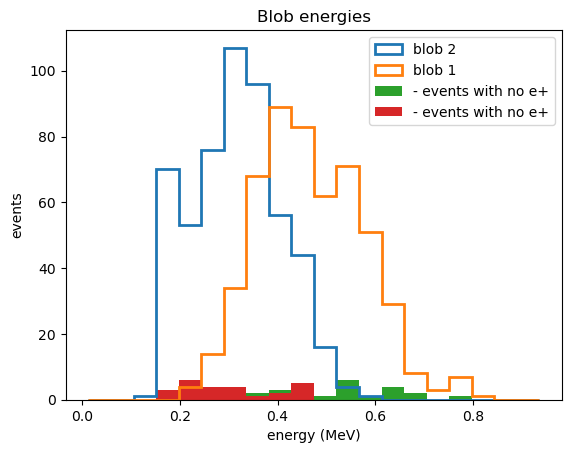




        CUT 0.2 MeV       


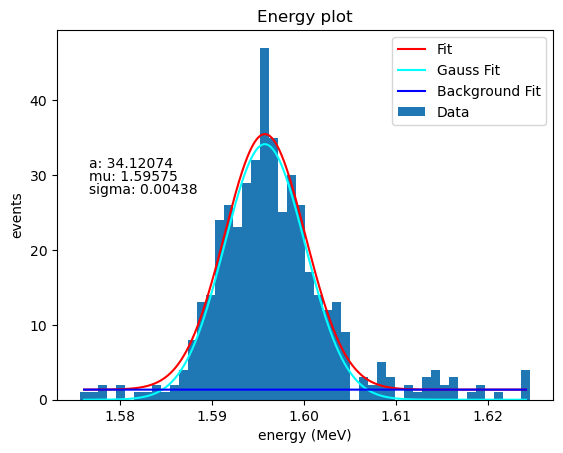

        Fitting output      
a: 34.1207 ± 1.3192
mu: 1.5957 ± 0.0002
sigma: 0.0044 ± 0.0002
C: 1.3474 ± 0.5646
ns - 382.6292842446868
nb - 275.36694063433157

e_i: 0.6505829821455625
b_i: 0.32183119215645806
fom: 1.1468025022641548


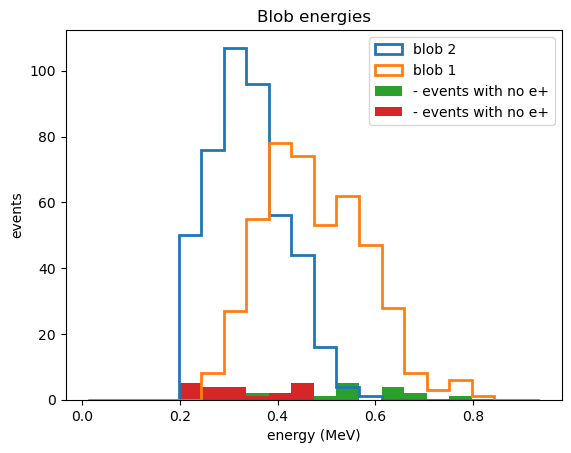

In [318]:
cut_list = [0, 0.05, 0.1, 0.15, 0.2]

# slim the data
slimmed_E = energy_cuts(ecut_rel, lower_e = 1.575, upper_e = 1.625, verbose = False)
slimmed_nopos = energy_cuts(ecut_no_positron_df, lower_e = 1.575, upper_e = 1.625, verbose = False)


fom_slimmed = fom_calc(slimmed_E, cut_list, no_pos_data = slimmed_nopos, verbose = True, binning = 50)

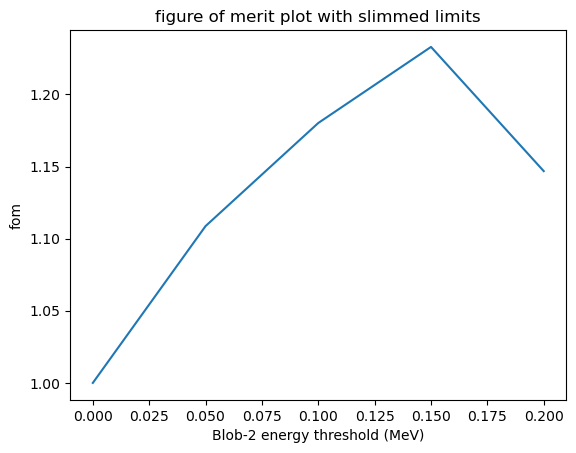

In [308]:
# plot fom
plt.plot(cut_list, fom_slimmed)
plt.title("figure of merit plot with slimmed limits")
plt.xlabel("Blob-2 energy threshold (MeV)")
plt.ylabel("fom")
plt.show()

#### trying normalised now

[150, 1.58, 0.006, 5]


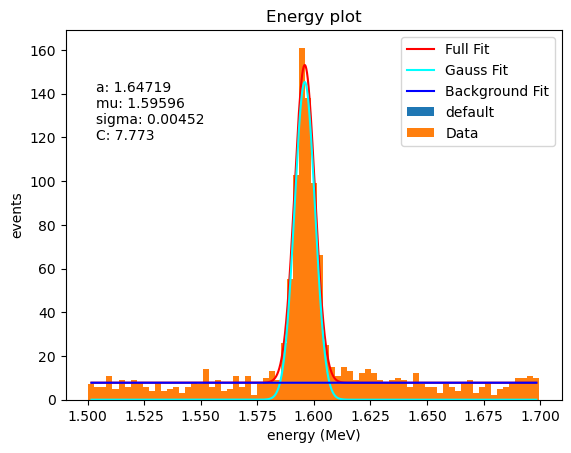

        Fitting output      
a: 1.6472 ± 0.0323
mu: 1.5960 ± 0.0001
sigma: 0.0045 ± 0.0001
C: 7.7730 ± 0.4667
ns = 1.6471888240374195
nb = 1.554600751309672
True ns = 620.0247178825308
True nb = 585.1732832233282


In [369]:
# collect heights from histogram of energy
hist, edges, patches = plot_hist(ecut_rel, binning = 75, output = False, data = True)
# convert edges to centres
centres = shift_to_bin_centers(edges)


# fitting
p0 = [150, 1.58, 0.006, 5]
gauss_bck_labels = ['a', 'mu', 'sigma', 'C']

print(p0)
popt, pcov = curve_fit(gauss_bck_norm, centres, hist, p0, maxfev = 5000000)
plot_fit(gauss_bck_norm, centres, popt, gauss_bck_labels, lgnd='Full Fit', colour = 'red', popt_text = False)
plot_fit(gauss_norm, centres, popt[:-1], gauss_bck_labels[:-1], lgnd = 'Gauss Fit', colour = 'cyan', popt_text = True)
plot_fit(bck, centres, [popt[-1]], gauss_bck_labels[-1], lgnd = 'Background Fit', colour = 'blue', popt_text = True)
plot_hist(ecut_rel, binning = 75, output = False, data = True, label='Data')
plt.legend()
plt.show()
print_parameters(popt, pcov, gauss_bck_labels)

bin_width = centres[1] - centres[0]

x_points = np.linspace(emin, emax, 100000)

ns0 = quad(gauss_norm, emin, emax, args = (popt[0], popt[1], popt[2]))
nb0 = quad(bck, emin, emax, args = popt[-1])
print('ns = {}'.format(ns0[0]))
print('nb = {}'.format(nb0[0]))

print('True ns = {}'.format(ns0[0]/bin_width))
print('True nb = {}'.format(nb0[0]/bin_width))